## Setup, Loading Data and CDFs

In [3]:
DATA_NAME = 'spaceNet-full' 
TRANSFORM = 'wavelet'
CHANNEL = 'gray'

In [4]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_wavelet_full_spaceNet.ipynb


In [5]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Volumes/SSD/hbmv/hierarchical-bayesian-model-validation/results/case-studies/spaceNet/full/wavelet/gray'

In [6]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [7]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [8]:
if TRANSFORM == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif TRANSFORM == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 27208,
 3: 108832,
 4: 333298,
 5: 1149538,
 6: 4251250,
 7: 17005000,
 8: 68020000,
 9: 272080000}

Running 12760 CDFs


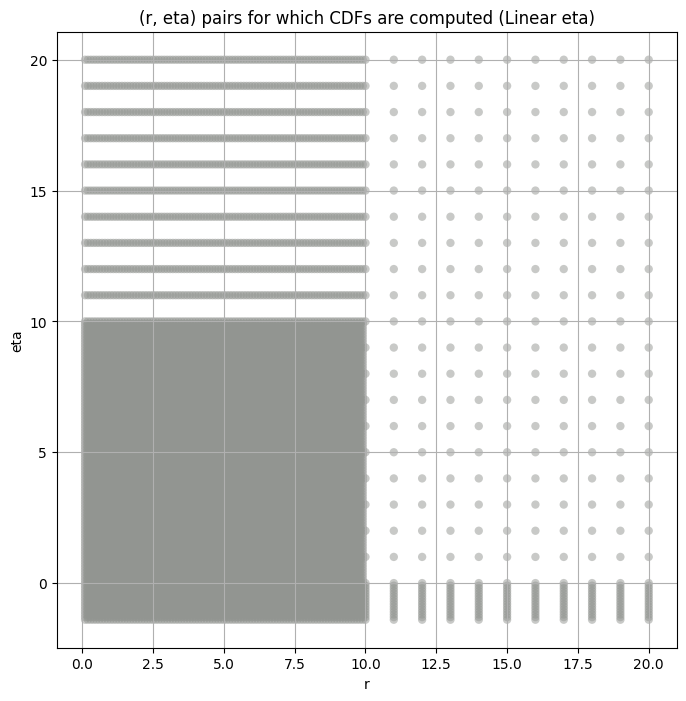

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [9]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [10]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [11]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


100%|██████████| 100000/100000 [00:19<00:00, 5003.72it/s]


Layer 3


100%|██████████| 100000/100000 [00:20<00:00, 4856.63it/s]


Layer 4


100%|██████████| 100000/100000 [00:20<00:00, 4820.02it/s]


Layer 5


100%|██████████| 100000/100000 [00:20<00:00, 4914.05it/s]


Layer 6


100%|██████████| 100000/100000 [00:21<00:00, 4664.75it/s]


Layer 7


100%|██████████| 100000/100000 [00:20<00:00, 4925.53it/s]


Layer 8


100%|██████████| 100000/100000 [00:20<00:00, 4933.95it/s]


Layer 9


100%|██████████| 100000/100000 [00:20<00:00, 4925.29it/s]


,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
layer,,,,,,,
2,18678.610000,17502.572000,19935.389000,4.316036,2.885068,6.460766,27208.0
3,5005.063500,4561.659000,5522.763000,11.797888,6.478233,25.283875,108832.0
4,1581.178100,1451.108800,1726.036900,9.157593,6.195280,16.083124,333298.0
5,447.847200,409.953770,492.383670,10.530340,6.367763,30.650787,1149538.0
6,107.281980,98.076250,117.780870,10.589932,6.834965,22.540855,4251250.0
7,23.563498,21.139431,26.704712,18.387585,9.488698,58.686512,17005000.0
8,5.003841,4.364752,6.037876,36.420383,13.384377,160.108230,68020000.0
9,0.925920,0.778517,1.293758,103.432570,15.223415,467.525050,272080000.0


## Initial Grid Search and Hypothesis Test Plots

In [12]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [13]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
layer,,,,,,,,,,,,
2,18678.610000,18678.609375,17565.789062,16957.357422,16472.001953,16041.406250,15295.377930,14656.122070,14094.214844,13593.154297,13134.911133,11956.469727
3,5005.063500,5005.063477,4770.622559,4658.641602,4570.672852,4493.978516,4361.866211,4248.301270,4147.132324,4055.487061,3971.161865,3751.993652
4,1581.178100,1581.178101,1521.707886,1487.666260,1460.024170,1436.250122,1395.217285,1359.591431,1327.851196,1298.912231,1272.231812,1202.586426
5,447.847200,447.847198,430.671417,421.088196,413.168365,406.256439,394.322357,384.022491,374.831390,366.502380,358.859528,338.831757
6,107.281980,107.281982,102.993286,100.544464,98.537270,96.798820,93.830772,91.294716,89.046974,87.010063,85.140282,80.257393
7,23.563498,23.563498,22.281857,21.620235,21.091091,20.638988,19.873688,19.226707,18.659775,18.151306,17.687799,16.492405
8,5.003841,5.003841,4.623041,4.445726,4.307621,4.191597,3.999341,3.840619,3.703673,3.582506,3.473461,3.197723
9,0.925920,0.925920,0.822245,0.786197,0.759037,0.736628,0.700156,0.670573,0.645395,0.623342,0.603646,0.554422


####
Layer  2


100%|██████████| 12760/12760 [00:07<00:00, 1676.84it/s]


Finding Minimum after computing 12760 CDFs
2 0 0.012739661355203602 18678.61


100%|██████████| 12760/12760 [00:07<00:00, 1725.70it/s]


Finding Minimum after computing 12760 CDFs
2 25 0.012724569039655853 17565.79


100%|██████████| 12760/12760 [00:07<00:00, 1733.83it/s]


Finding Minimum after computing 12760 CDFs
2 50 0.012716677984919877 16957.357


100%|██████████| 12760/12760 [00:07<00:00, 1738.88it/s]


Finding Minimum after computing 12760 CDFs
2 75 0.013493840322847173 16472.002


100%|██████████| 12760/12760 [00:07<00:00, 1741.49it/s]


Finding Minimum after computing 12760 CDFs
2 100 0.015315931676525674 16041.406


100%|██████████| 12760/12760 [00:07<00:00, 1732.65it/s]


Finding Minimum after computing 12760 CDFs
2 150 0.016877282849634523 15295.378


100%|██████████| 12760/12760 [00:07<00:00, 1742.62it/s]


Finding Minimum after computing 12760 CDFs
2 200 0.01717089133904115 14656.122


100%|██████████| 12760/12760 [00:07<00:00, 1730.37it/s]


Finding Minimum after computing 12760 CDFs
2 250 0.017442687979581595 14094.215


100%|██████████| 12760/12760 [00:07<00:00, 1740.61it/s]


Finding Minimum after computing 12760 CDFs
2 300 0.017673272773537252 13593.154


100%|██████████| 12760/12760 [00:07<00:00, 1743.03it/s]


Finding Minimum after computing 12760 CDFs
2 350 0.020504388952622743 13134.911


100%|██████████| 12760/12760 [00:07<00:00, 1739.74it/s]


Finding Minimum after computing 12760 CDFs
2 500 0.025302270991938824 11956.47
Number of samples: 27208, Without approximation : 27208.0


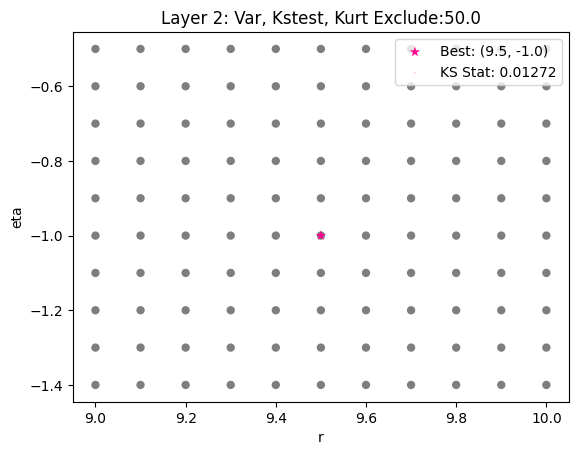

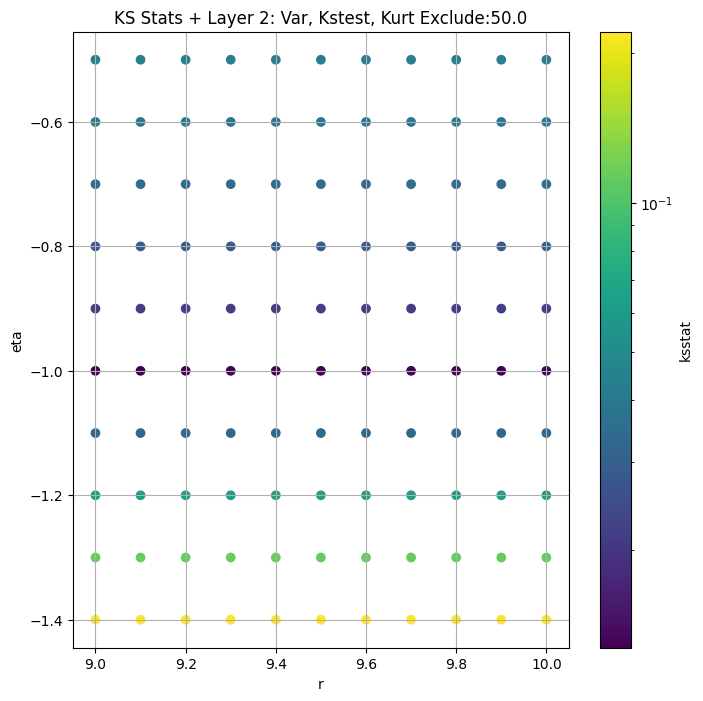

####
Layer  3


100%|██████████| 12760/12760 [00:27<00:00, 457.48it/s]


Finding Minimum after computing 12760 CDFs
3 0 0.13243999999999978 5005.0635


100%|██████████| 12760/12760 [00:27<00:00, 459.04it/s]


Finding Minimum after computing 12760 CDFs
3 25 0.13243999999999978 4770.6226


100%|██████████| 12760/12760 [00:27<00:00, 459.82it/s]


Finding Minimum after computing 12760 CDFs
3 50 0.13243999999999978 4658.6416


100%|██████████| 12760/12760 [00:27<00:00, 460.77it/s]


Finding Minimum after computing 12760 CDFs
3 75 0.13243999999999978 4570.673


100%|██████████| 12760/12760 [00:27<00:00, 460.46it/s]


Finding Minimum after computing 12760 CDFs
3 100 0.13243999999999978 4493.9785


100%|██████████| 12760/12760 [00:27<00:00, 460.70it/s]


Finding Minimum after computing 12760 CDFs
3 150 0.13243999999999978 4361.866


100%|██████████| 12760/12760 [00:27<00:00, 461.34it/s]


Finding Minimum after computing 12760 CDFs
3 200 0.13243999999999978 4248.3013


100%|██████████| 12760/12760 [00:27<00:00, 461.16it/s]


Finding Minimum after computing 12760 CDFs
3 250 0.13243999999999978 4147.1323


100%|██████████| 12760/12760 [00:28<00:00, 447.89it/s]


Finding Minimum after computing 12760 CDFs
3 300 0.13243999999999978 4055.487


100%|██████████| 12760/12760 [00:28<00:00, 455.04it/s]


Finding Minimum after computing 12760 CDFs
3 350 0.13243999999999978 3971.1619


100%|██████████| 12760/12760 [00:27<00:00, 463.00it/s]


Finding Minimum after computing 12760 CDFs
3 500 0.13243999999999978 3751.9937
Number of samples: 100000, Without approximation : 108832.0


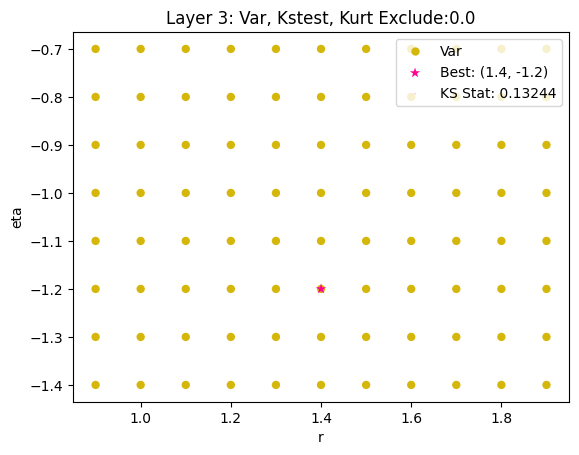

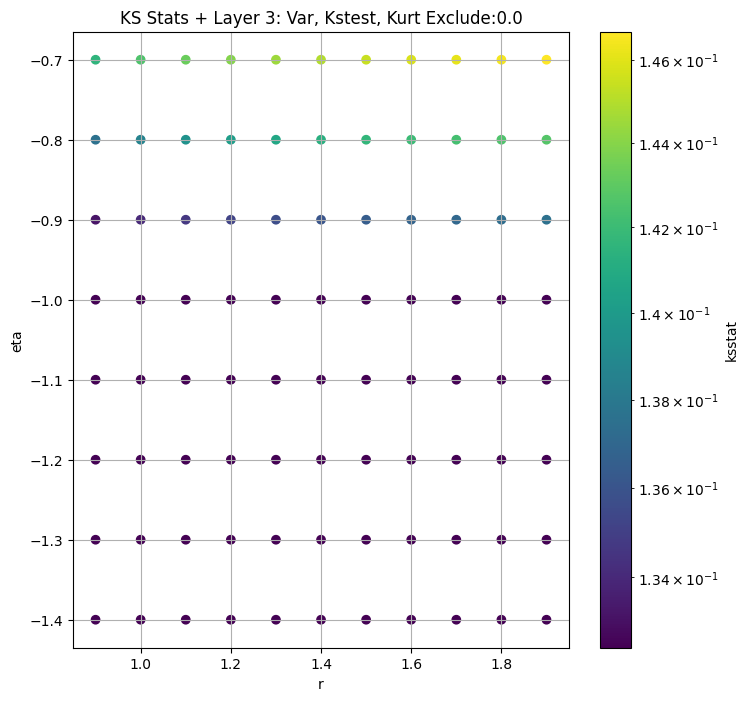

####
Layer  4


100%|██████████| 12760/12760 [00:27<00:00, 461.34it/s]


Finding Minimum after computing 12760 CDFs
4 0 0.0770699999999998 1581.1781


100%|██████████| 12760/12760 [00:27<00:00, 461.87it/s]


Finding Minimum after computing 12760 CDFs
4 25 0.0770699999999998 1521.7079


100%|██████████| 12760/12760 [00:28<00:00, 448.65it/s]


Finding Minimum after computing 12760 CDFs
4 50 0.0770699999999998 1487.6663


100%|██████████| 12760/12760 [00:29<00:00, 426.74it/s]


Finding Minimum after computing 12760 CDFs
4 75 0.0770699999999998 1460.0242


100%|██████████| 12760/12760 [00:29<00:00, 438.87it/s]


Finding Minimum after computing 12760 CDFs
4 100 0.0770699999999998 1436.2501


100%|██████████| 12760/12760 [00:30<00:00, 419.75it/s]


Finding Minimum after computing 12760 CDFs
4 150 0.0770699999999998 1395.2173


100%|██████████| 12760/12760 [00:30<00:00, 417.45it/s]


Finding Minimum after computing 12760 CDFs
4 200 0.0770699999999998 1359.5914


100%|██████████| 12760/12760 [00:31<00:00, 405.20it/s]


Finding Minimum after computing 12760 CDFs
4 250 0.0770699999999998 1327.8512


100%|██████████| 12760/12760 [00:30<00:00, 412.33it/s]


Finding Minimum after computing 12760 CDFs
4 300 0.0770699999999998 1298.9122


100%|██████████| 12760/12760 [00:30<00:00, 419.63it/s]


Finding Minimum after computing 12760 CDFs
4 350 0.0770699999999998 1272.2318


100%|██████████| 12760/12760 [00:30<00:00, 421.76it/s]


Finding Minimum after computing 12760 CDFs
4 500 0.0770699999999998 1202.5864
Number of samples: 100000, Without approximation : 333298.0


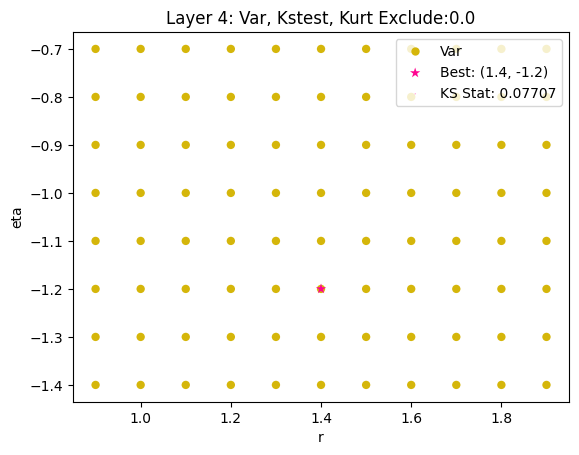

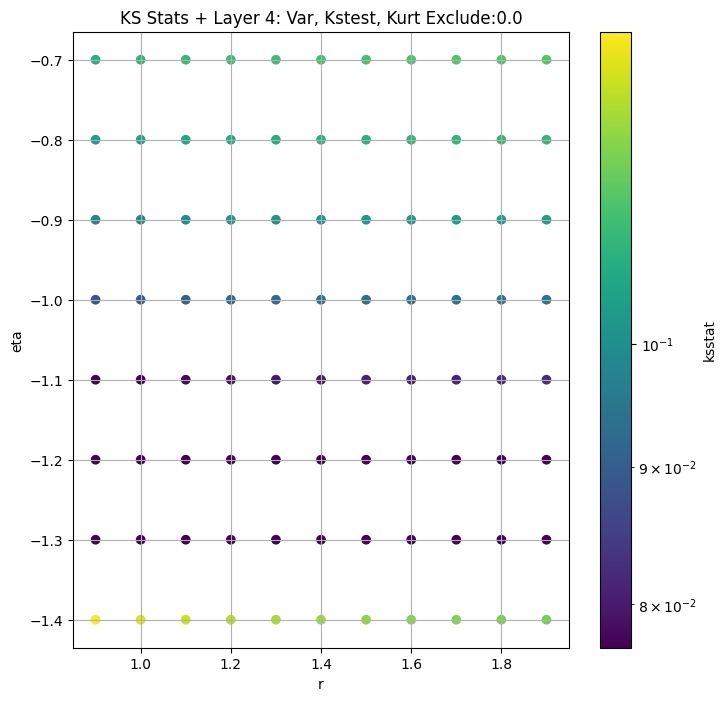

####
Layer  5


100%|██████████| 12760/12760 [00:29<00:00, 426.76it/s]


Finding Minimum after computing 12760 CDFs
5 0 0.042149999999999854 447.8472


100%|██████████| 12760/12760 [00:30<00:00, 425.21it/s]


Finding Minimum after computing 12760 CDFs
5 25 0.042149999999999854 430.67142


100%|██████████| 12760/12760 [00:30<00:00, 422.24it/s]


Finding Minimum after computing 12760 CDFs
5 50 0.042149999999999854 421.0882


100%|██████████| 12760/12760 [00:29<00:00, 426.49it/s]


Finding Minimum after computing 12760 CDFs
5 75 0.042149999999999854 413.16837


100%|██████████| 12760/12760 [00:29<00:00, 425.86it/s]


Finding Minimum after computing 12760 CDFs
5 100 0.042149999999999854 406.25644


100%|██████████| 12760/12760 [00:31<00:00, 403.06it/s]


Finding Minimum after computing 12760 CDFs
5 150 0.042149999999999854 394.32236


100%|██████████| 12760/12760 [00:29<00:00, 427.60it/s]


Finding Minimum after computing 12760 CDFs
5 200 0.042149999999999854 384.0225


100%|██████████| 12760/12760 [00:32<00:00, 392.13it/s]


Finding Minimum after computing 12760 CDFs
5 250 0.042149999999999854 374.8314


100%|██████████| 12760/12760 [00:31<00:00, 398.96it/s]


Finding Minimum after computing 12760 CDFs
5 300 0.042149999999999854 366.50238


100%|██████████| 12760/12760 [00:31<00:00, 401.44it/s]


Finding Minimum after computing 12760 CDFs
5 350 0.042149999999999854 358.85953


100%|██████████| 12760/12760 [00:31<00:00, 405.87it/s]


Finding Minimum after computing 12760 CDFs
5 500 0.04214999999999991 338.83176
Number of samples: 100000, Without approximation : 1149538.0


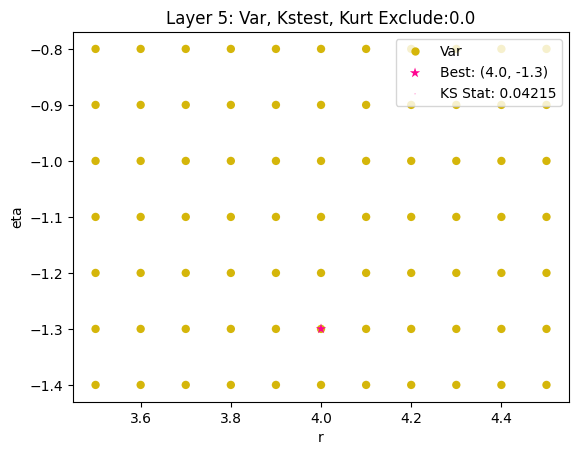

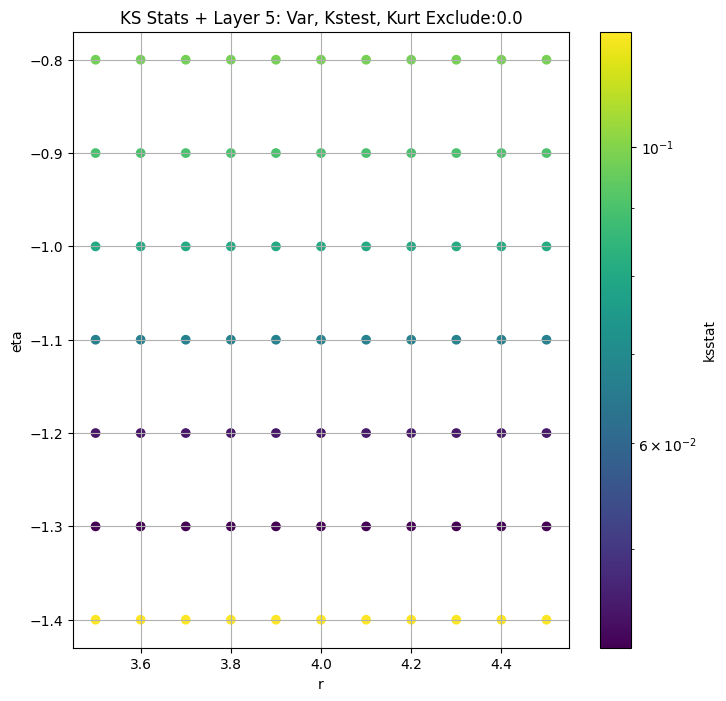

####
Layer  6


100%|██████████| 12760/12760 [00:30<00:00, 423.73it/s]


Finding Minimum after computing 12760 CDFs
6 0 0.013955176397370872 107.28198


100%|██████████| 12760/12760 [00:29<00:00, 429.23it/s]


Finding Minimum after computing 12760 CDFs
6 25 0.01424642183160485 102.993286


100%|██████████| 12760/12760 [00:30<00:00, 420.27it/s]


Finding Minimum after computing 12760 CDFs
6 50 0.0145257592536987 100.544464


100%|██████████| 12760/12760 [00:30<00:00, 423.57it/s]


Finding Minimum after computing 12760 CDFs
6 75 0.014429446967827886 98.53727


100%|██████████| 12760/12760 [00:32<00:00, 398.51it/s]


Finding Minimum after computing 12760 CDFs
6 100 0.014180003544525033 96.79882


100%|██████████| 12760/12760 [00:30<00:00, 412.54it/s]


Finding Minimum after computing 12760 CDFs
6 150 0.014345121498419822 93.83077


100%|██████████| 12760/12760 [00:32<00:00, 395.84it/s]


Finding Minimum after computing 12760 CDFs
6 200 0.014528520900351394 91.294716


100%|██████████| 12760/12760 [00:31<00:00, 408.29it/s]


Finding Minimum after computing 12760 CDFs
6 250 0.014649017479758886 89.046974


100%|██████████| 12760/12760 [00:32<00:00, 396.05it/s]


Finding Minimum after computing 12760 CDFs
6 300 0.014715780349912388 87.01006


100%|██████████| 12760/12760 [00:30<00:00, 414.49it/s]


Finding Minimum after computing 12760 CDFs
6 350 0.014738472511909628 85.14028


100%|██████████| 12760/12760 [00:32<00:00, 394.16it/s]


Finding Minimum after computing 12760 CDFs
6 500 0.014706804622111574 80.25739
Number of samples: 100000, Without approximation : 4251250.0


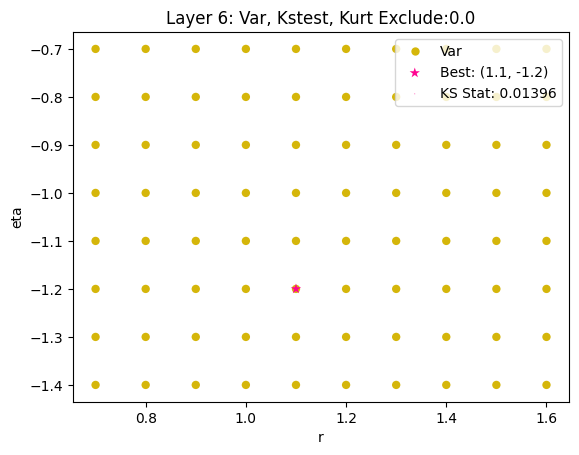

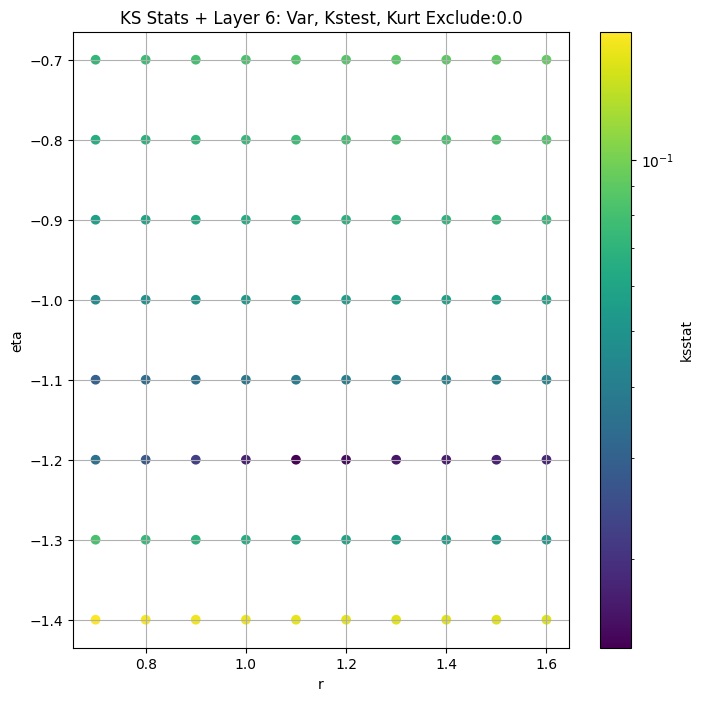

####
Layer  7


100%|██████████| 12760/12760 [00:29<00:00, 432.22it/s]


Finding Minimum after computing 12760 CDFs
7 0 0.01321289790230179 23.563498


100%|██████████| 12760/12760 [00:30<00:00, 424.04it/s]


Finding Minimum after computing 12760 CDFs
7 25 0.013022764335283599 22.281857


100%|██████████| 12760/12760 [00:29<00:00, 425.86it/s]


Finding Minimum after computing 12760 CDFs
7 50 0.013013032689367043 21.620235


100%|██████████| 12760/12760 [00:29<00:00, 438.57it/s]


Finding Minimum after computing 12760 CDFs
7 75 0.013227598504031213 21.091091


100%|██████████| 12760/12760 [00:29<00:00, 436.42it/s]


Finding Minimum after computing 12760 CDFs
7 100 0.013123149613633589 20.638988


100%|██████████| 12760/12760 [00:29<00:00, 435.20it/s]


Finding Minimum after computing 12760 CDFs
7 150 0.013003723805405376 19.873688


100%|██████████| 12760/12760 [00:29<00:00, 432.69it/s]


Finding Minimum after computing 12760 CDFs
7 200 0.012941189910385065 19.226707


100%|██████████| 12760/12760 [00:29<00:00, 432.88it/s]


Finding Minimum after computing 12760 CDFs
7 250 0.012962229143061554 18.659775


100%|██████████| 12760/12760 [00:31<00:00, 407.67it/s]


Finding Minimum after computing 12760 CDFs
7 300 0.012796824566932097 18.151306


100%|██████████| 12760/12760 [00:30<00:00, 423.68it/s]


Finding Minimum after computing 12760 CDFs
7 350 0.012948740471078413 17.6878


100%|██████████| 12760/12760 [00:30<00:00, 414.70it/s]


Finding Minimum after computing 12760 CDFs
7 500 0.012837823645574842 16.492405
Number of samples: 100000, Without approximation : 17005000.0


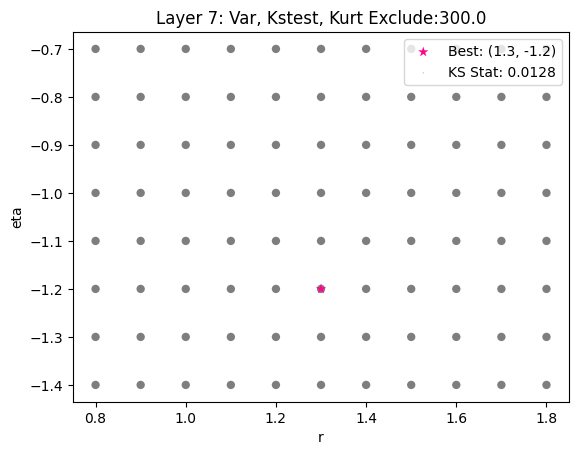

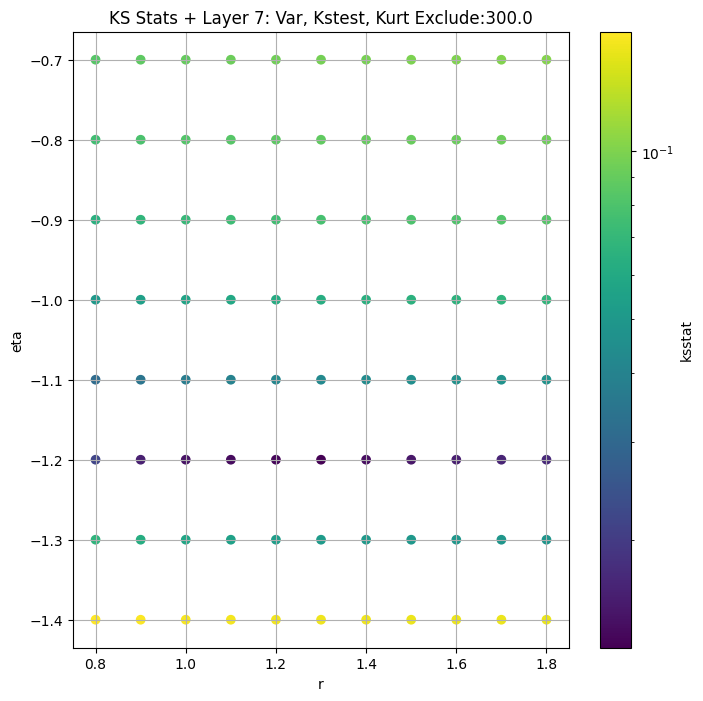

####
Layer  8


100%|██████████| 12760/12760 [00:29<00:00, 430.78it/s]


Finding Minimum after computing 12760 CDFs
8 0 0.012599459973051563 5.0038414


100%|██████████| 12760/12760 [00:28<00:00, 443.53it/s]


Finding Minimum after computing 12760 CDFs
8 25 0.009946300247381024 4.6230407


100%|██████████| 12760/12760 [00:28<00:00, 444.78it/s]


Finding Minimum after computing 12760 CDFs
8 50 0.012044873213257173 4.445726


100%|██████████| 12760/12760 [00:29<00:00, 439.26it/s]


Finding Minimum after computing 12760 CDFs
8 75 0.013763713875673086 4.3076215


100%|██████████| 12760/12760 [00:28<00:00, 442.95it/s]


Finding Minimum after computing 12760 CDFs
8 100 0.013269830228536783 4.1915965


100%|██████████| 12760/12760 [00:29<00:00, 430.54it/s]


Finding Minimum after computing 12760 CDFs
8 150 0.011264699596132743 3.9993412


100%|██████████| 12760/12760 [00:29<00:00, 432.90it/s]


Finding Minimum after computing 12760 CDFs
8 200 0.011930388048114304 3.8406186


100%|██████████| 12760/12760 [00:29<00:00, 431.98it/s]


Finding Minimum after computing 12760 CDFs
8 250 0.013246843162087088 3.7036734


100%|██████████| 12760/12760 [00:30<00:00, 420.58it/s]


Finding Minimum after computing 12760 CDFs
8 300 0.014987718075658088 3.5825062


100%|██████████| 12760/12760 [00:31<00:00, 409.18it/s]


Finding Minimum after computing 12760 CDFs
8 350 0.015604126010178632 3.4734612


100%|██████████| 12760/12760 [00:30<00:00, 415.82it/s]


Finding Minimum after computing 12760 CDFs
8 500 0.016976252925878732 3.1977234
Number of samples: 100000, Without approximation : 68020000.0


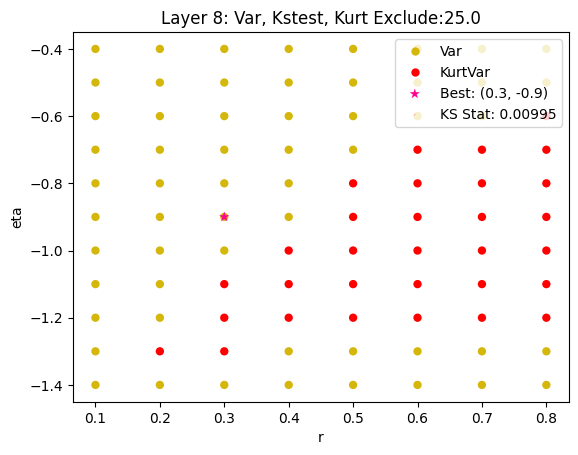

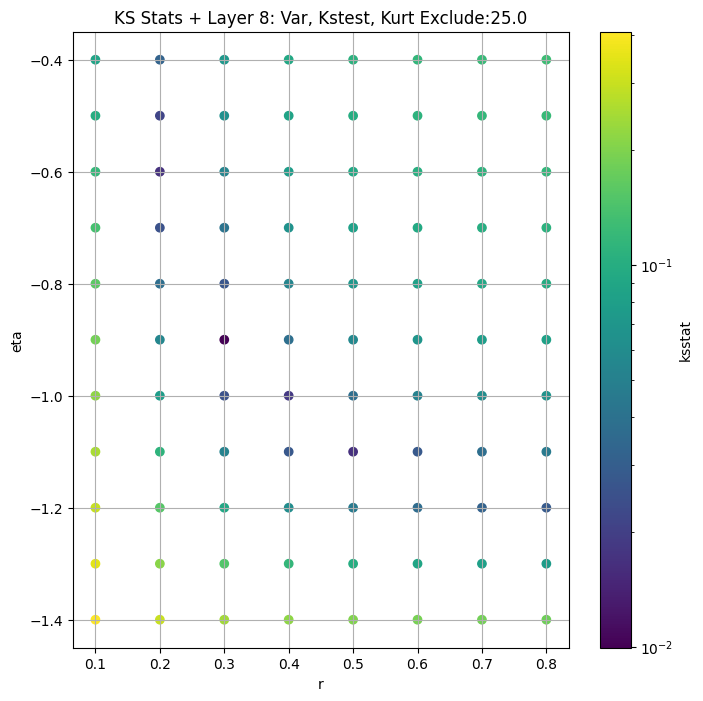

####
Layer  9


100%|██████████| 12760/12760 [00:31<00:00, 399.72it/s]


Finding Minimum after computing 12760 CDFs
9 0 0.009484366679373246 0.9259198


100%|██████████| 12760/12760 [00:30<00:00, 419.68it/s]


Finding Minimum after computing 12760 CDFs
9 25 0.007459515303804065 0.8222446


100%|██████████| 12760/12760 [00:30<00:00, 412.04it/s]


Finding Minimum after computing 12760 CDFs
9 50 0.007459527633229435 0.7861974


100%|██████████| 12760/12760 [00:29<00:00, 430.72it/s]


Finding Minimum after computing 12760 CDFs
9 75 0.008504640455357926 0.75903654


100%|██████████| 12760/12760 [00:29<00:00, 436.75it/s]


Finding Minimum after computing 12760 CDFs
9 100 0.008741092744687054 0.73662776


100%|██████████| 12760/12760 [00:29<00:00, 430.49it/s]


Finding Minimum after computing 12760 CDFs
9 150 0.009986238740587239 0.70015615


100%|██████████| 12760/12760 [00:29<00:00, 432.82it/s]


Finding Minimum after computing 12760 CDFs
9 200 0.008205174246184714 0.6705727


100%|██████████| 12760/12760 [00:29<00:00, 434.56it/s]


Finding Minimum after computing 12760 CDFs
9 250 0.00999385276079856 0.64539486


100%|██████████| 12760/12760 [00:29<00:00, 435.19it/s]


Finding Minimum after computing 12760 CDFs
9 300 0.010007206096727221 0.62334174


100%|██████████| 12760/12760 [00:28<00:00, 440.23it/s]


Finding Minimum after computing 12760 CDFs
9 350 0.009378904706894065 0.6036455


100%|██████████| 12760/12760 [02:45<00:00, 77.02it/s] 


Finding Minimum after computing 12760 CDFs
9 500 0.010331103557624455 0.55442196
Number of samples: 100000, Without approximation : 272080000.0


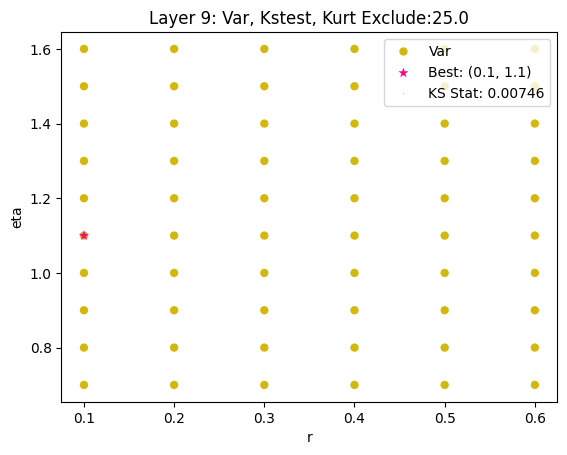

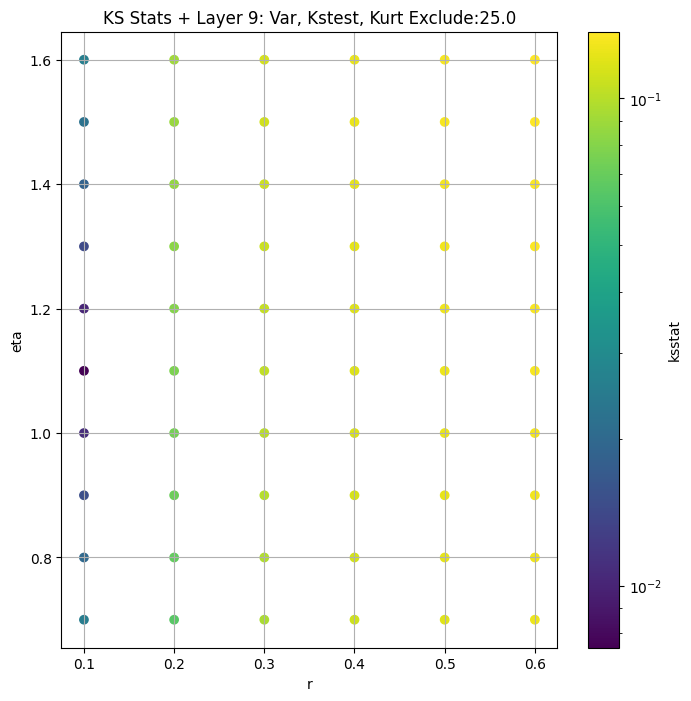

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
layer,,,,,,,,,,,,,,
2,18678.610000,17502.572000,19935.389000,4.316036,2.885068,6.460766,27208.0,0.012717,9.5,-1.0,5.315531e+04,50.0,16957.357000,0.008227
3,5005.063500,4561.659000,5522.763000,11.797888,6.478233,25.283875,108832.0,0.132440,1.4,-1.2,2.040829e+04,0.0,5005.063500,0.004115
4,1581.178100,1451.108800,1726.036900,9.157593,6.195280,16.083124,333298.0,0.077070,1.4,-1.2,6.447298e+03,0.0,1581.178100,0.002352
5,447.847200,409.953770,492.383670,10.530340,6.367763,30.650787,1149538.0,0.042150,4.0,-1.3,2.914732e+03,0.0,447.847200,0.001267
6,107.281980,98.076250,117.780870,10.589932,6.834965,22.540855,4251250.0,0.013955,1.1,-1.2,3.843359e+02,0.0,107.281980,0.000659
7,23.563498,21.139431,26.704712,18.387585,9.488698,58.686512,17005000.0,0.012797,1.3,-1.2,7.162218e+01,300.0,18.151306,0.000329
8,5.003841,4.364752,6.037876,36.420383,13.384377,160.108230,68020000.0,0.009946,0.3,-0.9,1.152046e-01,25.0,4.623041,0.000165
9,0.925920,0.778517,1.293758,103.432570,15.223415,467.525050,272080000.0,0.007460,0.1,1.1,1.234281e-15,25.0,0.822245,0.000082


In [14]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [15]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


100%|██████████| 81/81 [00:00<00:00, 1502.20it/s]


Finding Minimum after computing 81 CDFs
layer 2, 50.0 + 100 = 150, ksstat: 0.01918455740867908, var: 15295.3779296875


100%|██████████| 81/81 [00:00<00:00, 1565.31it/s]


Finding Minimum after computing 81 CDFs
layer 2, 50.0 + 75 = 125, ksstat: 0.01753411899254964, var: 15652.095703125


100%|██████████| 81/81 [00:00<00:00, 1518.45it/s]


Finding Minimum after computing 81 CDFs
layer 2, 50.0 + 50 = 100, ksstat: 0.015782692442863788, var: 16041.40625


100%|██████████| 81/81 [00:00<00:00, 1546.28it/s]


Finding Minimum after computing 81 CDFs
layer 2, 50.0 + 25 = 75, ksstat: 0.013950595519134357, var: 16472.001953125


100%|██████████| 81/81 [00:00<00:00, 1597.85it/s]


Finding Minimum after computing 81 CDFs
layer 2, 50.0 + 0 = 50, ksstat: 0.012716677984919877, var: 16957.357421875


100%|██████████| 81/81 [00:00<00:00, 1594.68it/s]


Finding Minimum after computing 81 CDFs
layer 2, 50.0 + -25 = 25, ksstat: 0.013177890666227432, var: 17565.7890625


100%|██████████| 81/81 [00:00<00:00, 1604.24it/s]


Finding Minimum after computing 81 CDFs
layer 2, 50.0 + -50 = 0, ksstat: 0.013994155012924947, var: 18678.609375
Number of samples: 27208, Without approximation : 27208.0


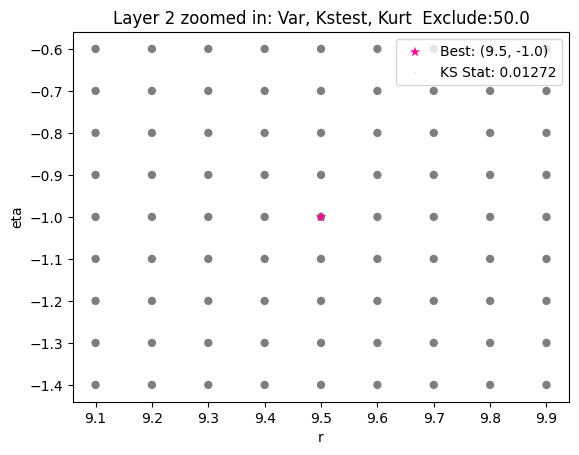

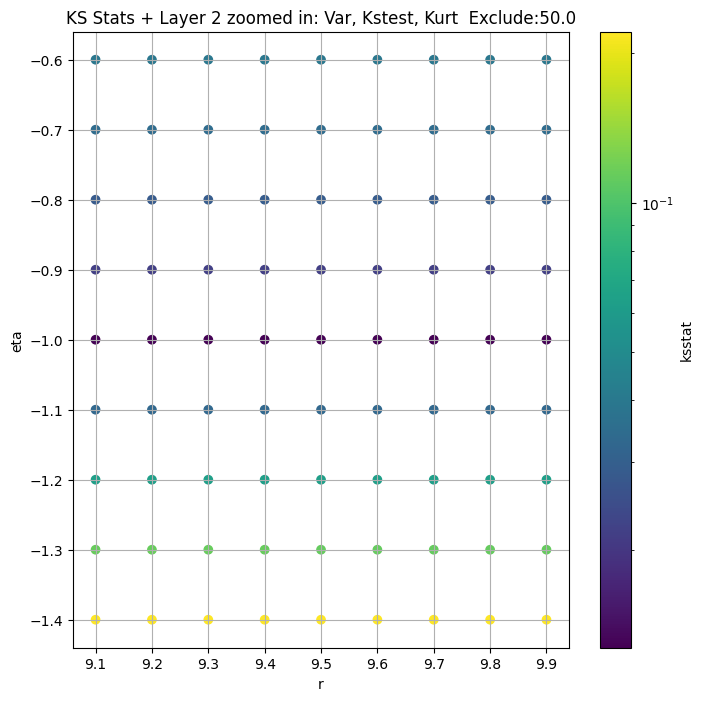

Layer 3


100%|██████████| 1380/1380 [00:03<00:00, 412.28it/s]


Finding Minimum after computing 1380 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.13243999999999972, var: 4493.978515625


100%|██████████| 1380/1380 [00:03<00:00, 450.59it/s]


Finding Minimum after computing 1380 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.13243999999999972, var: 4570.6728515625


100%|██████████| 1380/1380 [00:03<00:00, 449.14it/s]


Finding Minimum after computing 1380 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.13243999999999972, var: 4658.6416015625


100%|██████████| 1380/1380 [00:03<00:00, 404.83it/s]


Finding Minimum after computing 1380 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.13243999999999972, var: 4770.62255859375


100%|██████████| 1380/1380 [00:03<00:00, 445.67it/s]


Finding Minimum after computing 1380 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.13243999999999972, var: 5005.0634765625
Number of samples: 100000, Without approximation : 108832.0


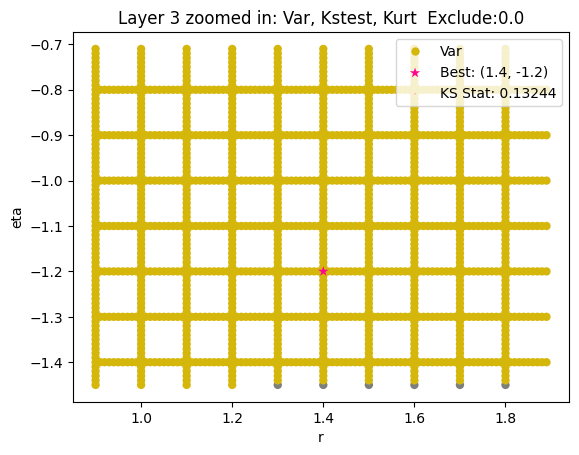

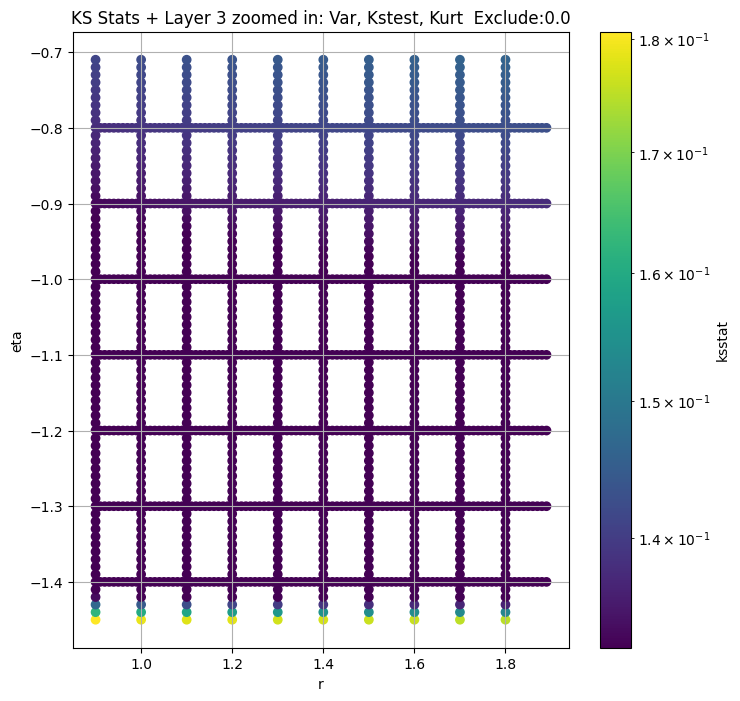

Layer 4


100%|██████████| 1380/1380 [00:03<00:00, 443.35it/s]


Finding Minimum after computing 1380 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.07706999999999975, var: 1436.2501220703125


100%|██████████| 1380/1380 [00:03<00:00, 443.30it/s]


Finding Minimum after computing 1380 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.07706999999999975, var: 1460.024169921875


100%|██████████| 1380/1380 [00:03<00:00, 438.06it/s]


Finding Minimum after computing 1380 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.07706999999999975, var: 1487.666259765625


100%|██████████| 1380/1380 [00:03<00:00, 438.71it/s]


Finding Minimum after computing 1380 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.07706999999999975, var: 1521.7078857421875


100%|██████████| 1380/1380 [00:03<00:00, 444.21it/s]


Finding Minimum after computing 1380 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.07706999999999975, var: 1581.1781005859375
Number of samples: 100000, Without approximation : 333298.0


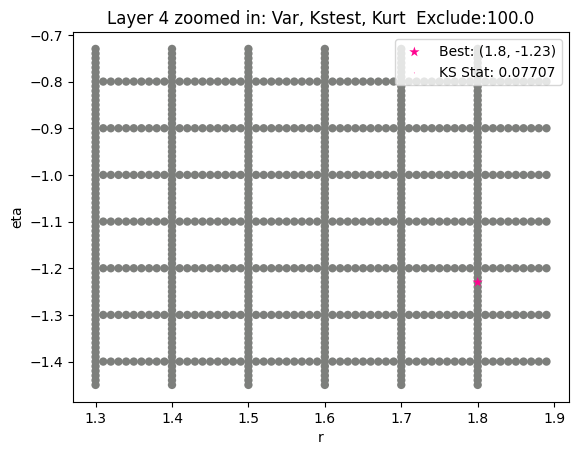

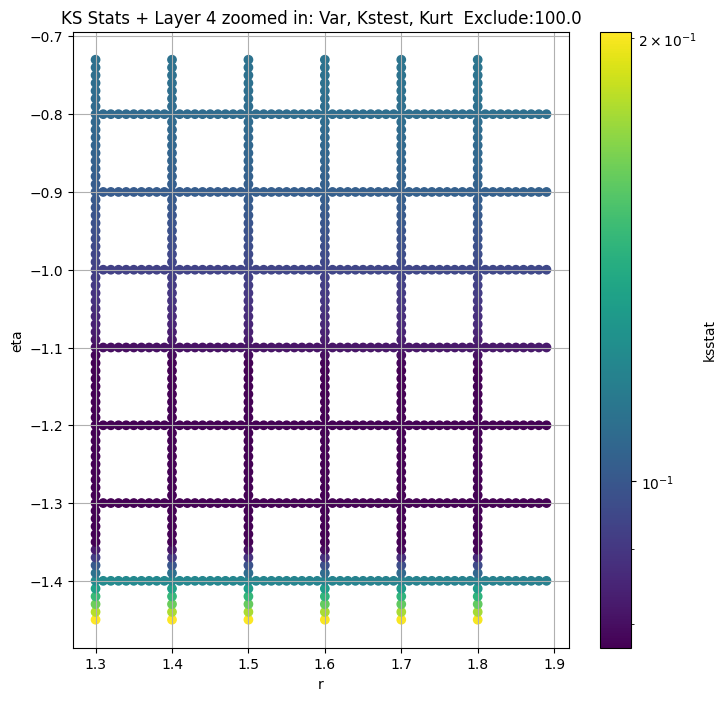

Layer 5


100%|██████████| 113/113 [00:00<00:00, 446.12it/s]


Finding Minimum after computing 113 CDFs
layer 5, 0.0 + 100 = 100, ksstat: 0.042149999999999854, var: 406.2564392089844


100%|██████████| 113/113 [00:00<00:00, 445.90it/s]


Finding Minimum after computing 113 CDFs
layer 5, 0.0 + 75 = 75, ksstat: 0.042149999999999854, var: 413.1683654785156


100%|██████████| 113/113 [00:00<00:00, 443.71it/s]


Finding Minimum after computing 113 CDFs
layer 5, 0.0 + 50 = 50, ksstat: 0.042149999999999854, var: 421.08819580078125


100%|██████████| 113/113 [00:00<00:00, 448.19it/s]


Finding Minimum after computing 113 CDFs
layer 5, 0.0 + 25 = 25, ksstat: 0.042149999999999854, var: 430.6714172363281


100%|██████████| 113/113 [00:00<00:00, 451.56it/s]


Finding Minimum after computing 113 CDFs
layer 5, 0.0 + 0 = 0, ksstat: 0.042149999999999854, var: 447.8471984863281
Number of samples: 100000, Without approximation : 1149538.0


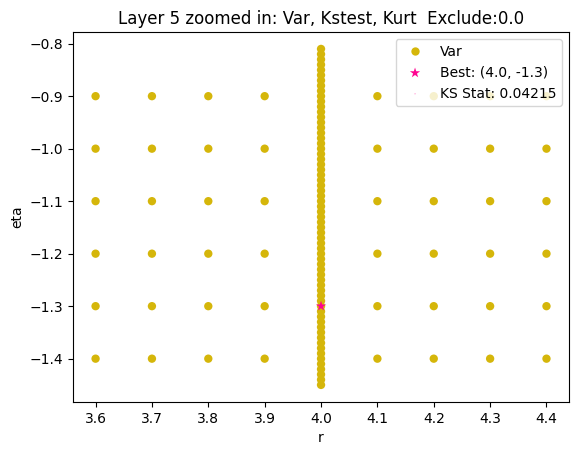

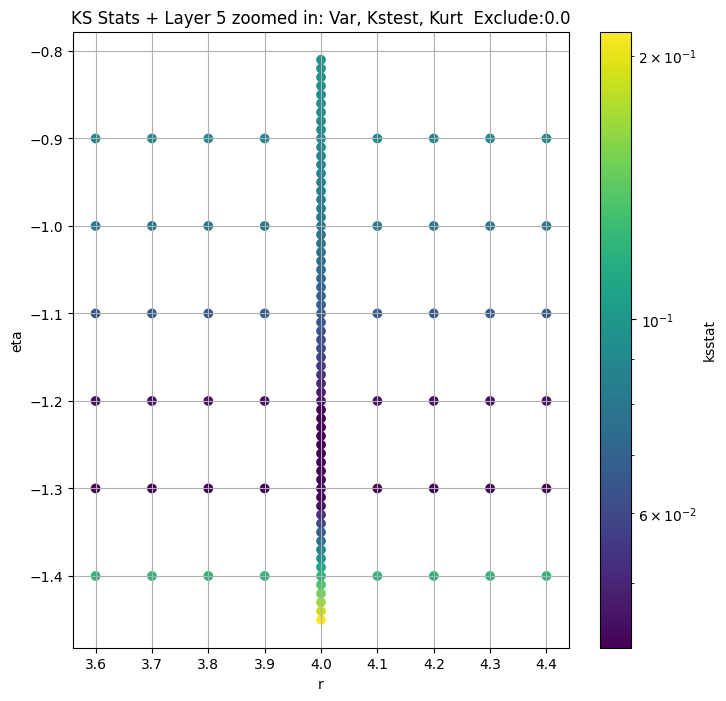

Layer 6


100%|██████████| 1305/1305 [00:02<00:00, 444.48it/s]


Finding Minimum after computing 1305 CDFs
layer 6, 0.0 + 100 = 100, ksstat: 0.014068990890353794, var: 96.79882049560547


100%|██████████| 1305/1305 [00:02<00:00, 444.17it/s]


Finding Minimum after computing 1305 CDFs
layer 6, 0.0 + 75 = 75, ksstat: 0.013139489056434972, var: 98.53726959228516


100%|██████████| 1305/1305 [00:02<00:00, 442.83it/s]


Finding Minimum after computing 1305 CDFs
layer 6, 0.0 + 50 = 50, ksstat: 0.012962484248930206, var: 100.54446411132812


100%|██████████| 1305/1305 [00:02<00:00, 451.40it/s]


Finding Minimum after computing 1305 CDFs
layer 6, 0.0 + 25 = 25, ksstat: 0.012712973941575889, var: 102.9932861328125


100%|██████████| 1305/1305 [00:02<00:00, 450.93it/s]


Finding Minimum after computing 1305 CDFs
layer 6, 0.0 + 0 = 0, ksstat: 0.012641241267140502, var: 107.281982421875
Number of samples: 100000, Without approximation : 4251250.0


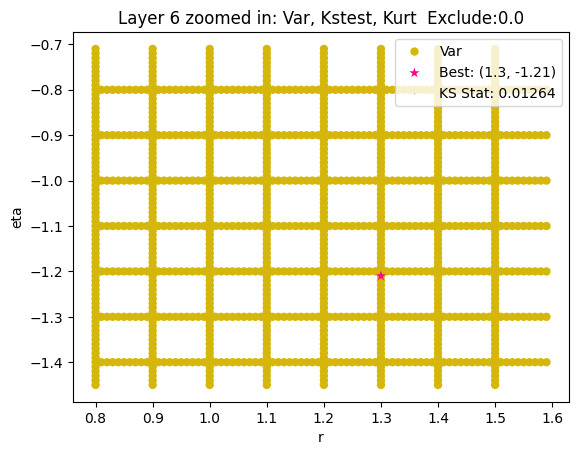

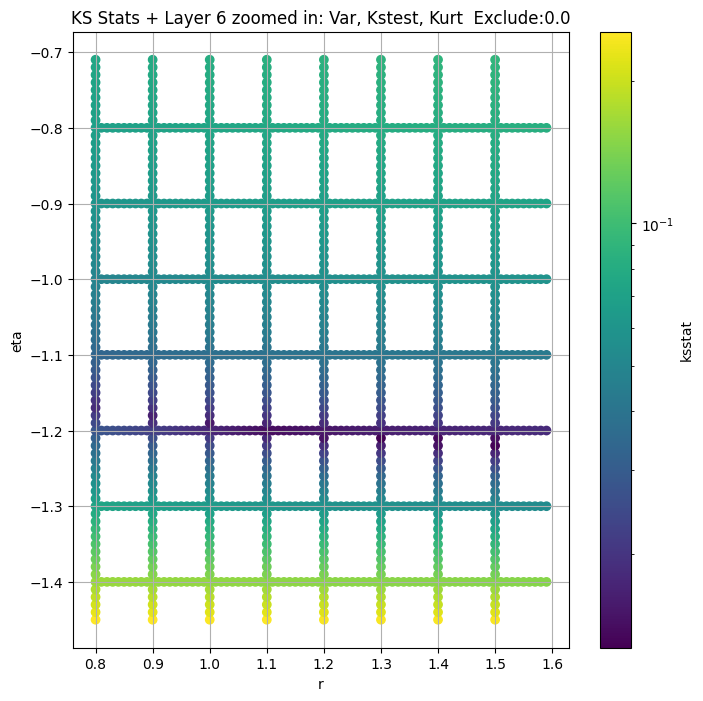

Layer 7


100%|██████████| 1305/1305 [00:02<00:00, 449.98it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 300.0 + 100 = 400, ksstat: 0.012165029175413677, var: 17.260438919067383


100%|██████████| 1305/1305 [00:02<00:00, 451.98it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 300.0 + 75 = 375, ksstat: 0.012216920596066716, var: 17.469987869262695


100%|██████████| 1305/1305 [00:02<00:00, 450.82it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 300.0 + 50 = 350, ksstat: 0.012548636388148626, var: 17.68779945373535


100%|██████████| 1305/1305 [00:02<00:00, 444.42it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 300.0 + 25 = 325, ksstat: 0.011776103719951941, var: 17.914525985717773


100%|██████████| 1305/1305 [00:02<00:00, 452.98it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 300.0 + 0 = 300, ksstat: 0.011858898511940885, var: 18.15130615234375


100%|██████████| 1305/1305 [00:02<00:00, 450.95it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 300.0 + -25 = 275, ksstat: 0.012225858052058669, var: 18.399261474609375


100%|██████████| 1305/1305 [00:02<00:00, 448.60it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 300.0 + -50 = 250, ksstat: 0.012224789560297267, var: 18.659774780273438


100%|██████████| 1305/1305 [00:02<00:00, 449.47it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 300.0 + -75 = 225, ksstat: 0.012235895363163385, var: 18.934738159179688


100%|██████████| 1305/1305 [00:02<00:00, 442.71it/s]


Finding Minimum after computing 1305 CDFs
layer 7, 300.0 + -100 = 200, ksstat: 0.012659320535329144, var: 19.226707458496094
Number of samples: 100000, Without approximation : 17005000.0


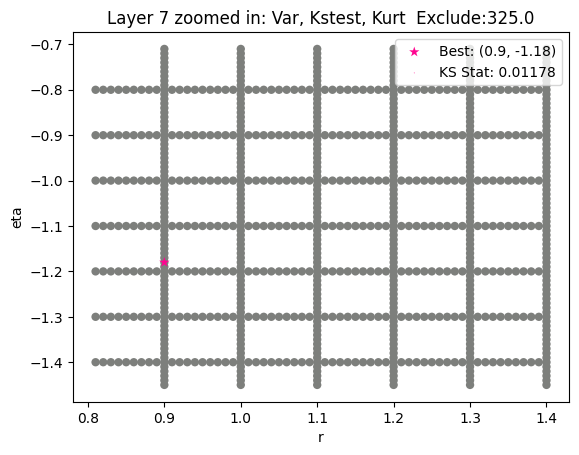

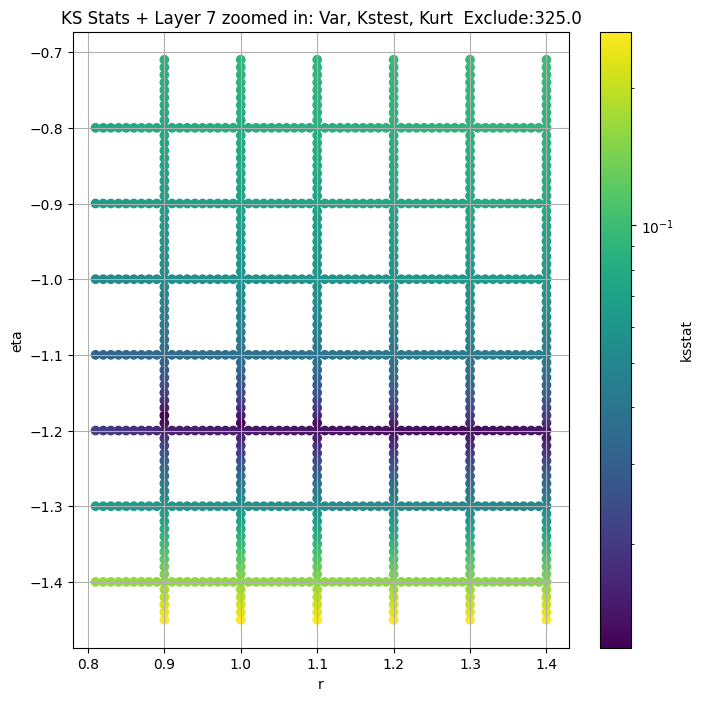

Layer 8


100%|██████████| 1410/1410 [00:03<00:00, 444.03it/s]


Finding Minimum after computing 1410 CDFs
layer 8, 25.0 + 100 = 125, ksstat: 0.011917375178161771, var: 4.090153694152832


100%|██████████| 1410/1410 [00:03<00:00, 452.21it/s]


Finding Minimum after computing 1410 CDFs
layer 8, 25.0 + 75 = 100, ksstat: 0.011363827234970536, var: 4.191596508026123


100%|██████████| 1410/1410 [00:03<00:00, 450.17it/s]


Finding Minimum after computing 1410 CDFs
layer 8, 25.0 + 50 = 75, ksstat: 0.011361105191363394, var: 4.307621479034424


100%|██████████| 1410/1410 [00:03<00:00, 447.55it/s]


Finding Minimum after computing 1410 CDFs
layer 8, 25.0 + 25 = 50, ksstat: 0.010874908445799747, var: 4.445725917816162


100%|██████████| 1410/1410 [00:03<00:00, 452.22it/s]


Finding Minimum after computing 1410 CDFs
layer 8, 25.0 + 0 = 25, ksstat: 0.009946300247381024, var: 4.623040676116943


100%|██████████| 1410/1410 [00:03<00:00, 446.56it/s]


Finding Minimum after computing 1410 CDFs
layer 8, 25.0 + -25 = 0, ksstat: 0.009915248750767991, var: 5.003841400146484
Number of samples: 100000, Without approximation : 68020000.0


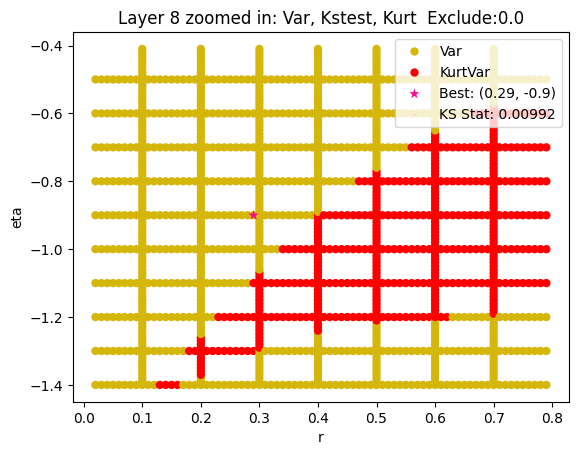

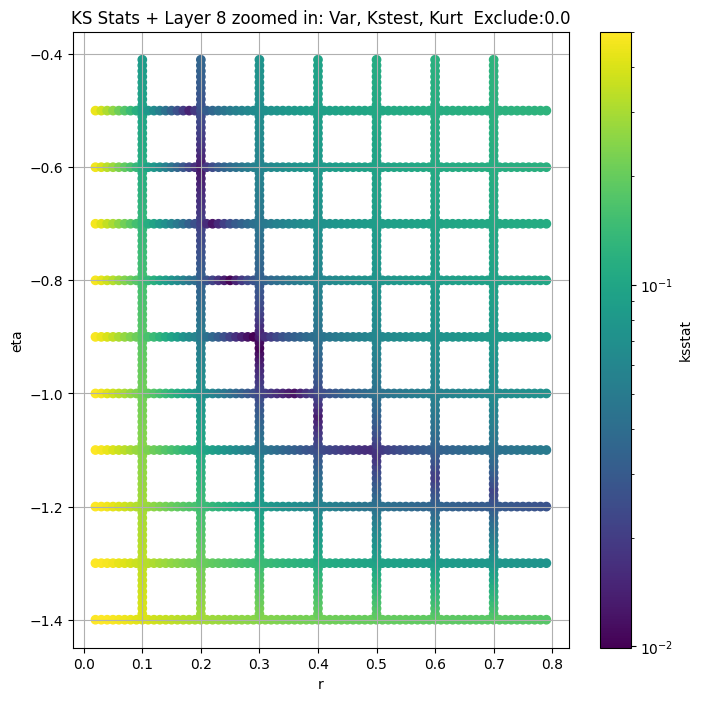

Layer 9


100%|██████████| 522/522 [00:01<00:00, 368.92it/s]


Finding Minimum after computing 522 CDFs
layer 9, 25.0 + 100 = 125, ksstat: 0.008695648700616579, var: 0.7172885537147522


100%|██████████| 522/522 [00:01<00:00, 463.84it/s]


Finding Minimum after computing 522 CDFs
layer 9, 25.0 + 75 = 100, ksstat: 0.0080104420728688, var: 0.7366277575492859


100%|██████████| 522/522 [00:01<00:00, 462.48it/s]


Finding Minimum after computing 522 CDFs
layer 9, 25.0 + 50 = 75, ksstat: 0.00745952861526078, var: 0.7590365409851074


100%|██████████| 522/522 [00:01<00:00, 471.51it/s]


Finding Minimum after computing 522 CDFs
layer 9, 25.0 + 25 = 50, ksstat: 0.007459512278342739, var: 0.7861974239349365


100%|██████████| 522/522 [00:01<00:00, 466.92it/s]


Finding Minimum after computing 522 CDFs
layer 9, 25.0 + 0 = 25, ksstat: 0.007459515303804065, var: 0.8222445845603943


100%|██████████| 522/522 [00:01<00:00, 450.33it/s]


Finding Minimum after computing 522 CDFs
layer 9, 25.0 + -25 = 0, ksstat: 0.008849339671625933, var: 0.925919771194458
Number of samples: 100000, Without approximation : 272080000.0


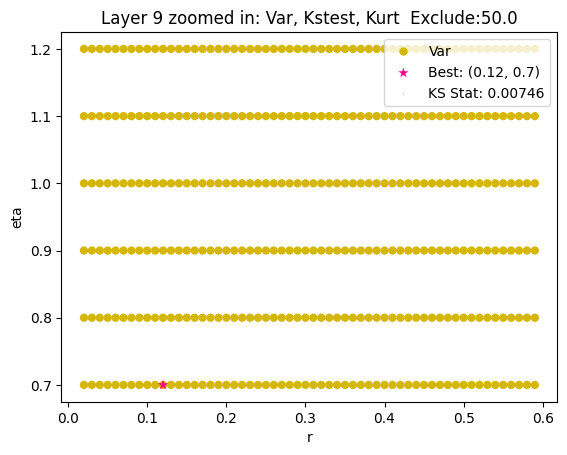

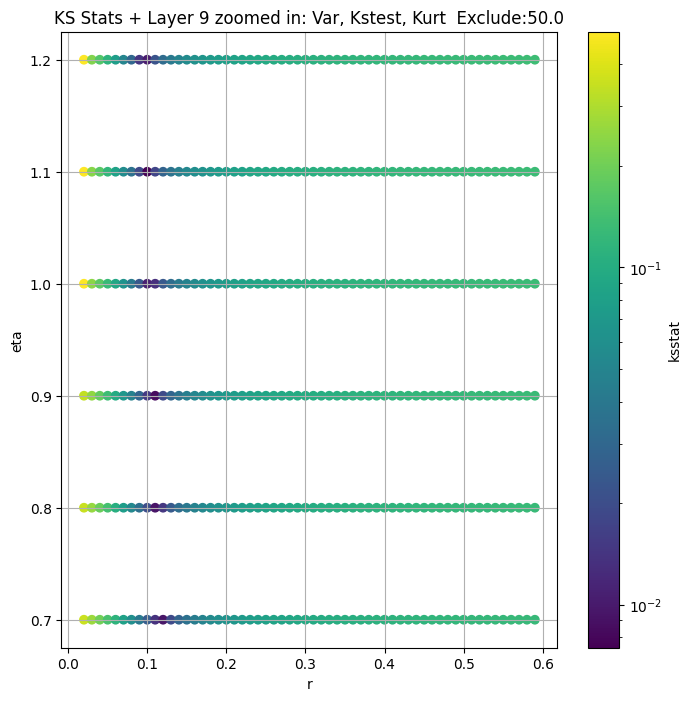

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
layer,,,,,,,,,,,,,,,,,,,,
2,18678.610000,17502.572000,19935.389000,4.316036,2.885068,6.460766,27208.0,0.012717,9.5,-1.0,5.315531e+04,50.0,16957.357000,0.008227,0.012717,9.50,-1.00,5.315531e+04,50.0,11478
3,5005.063500,4561.659000,5522.763000,11.797888,6.478233,25.283875,108832.0,0.132440,1.4,-1.2,2.040829e+04,0.0,5005.063500,0.004115,0.132440,1.40,-1.20,2.040829e+04,0.0,106
4,1581.178100,1451.108800,1726.036900,9.157593,6.195280,16.083124,333298.0,0.077070,1.4,-1.2,6.447298e+03,0.0,1436.250122,0.002352,0.077070,1.80,-1.23,6.929007e+03,100.0,306
5,447.847200,409.953770,492.383670,10.530340,6.367763,30.650787,1149538.0,0.042150,4.0,-1.3,2.914732e+03,0.0,447.847200,0.001267,0.042150,4.00,-1.30,2.914732e+03,0.0,1062
6,107.281980,98.076250,117.780870,10.589932,6.834965,22.540855,4251250.0,0.013955,1.1,-1.2,3.843359e+02,0.0,107.281982,0.000659,0.012641,1.30,-1.21,4.368110e+02,0.0,11820
7,23.563498,21.139431,26.704712,18.387585,9.488698,58.686512,17005000.0,0.012797,1.3,-1.2,7.162218e+01,300.0,17.914526,0.000329,0.011776,0.90,-1.18,5.066840e+01,325.0,14010
8,5.003841,4.364752,6.037876,36.420383,13.384377,160.108230,68020000.0,0.009946,0.3,-0.9,1.152046e-01,25.0,5.003841,0.000165,0.009915,0.29,-0.90,9.587160e-02,0.0,18681
9,0.925920,0.778517,1.293758,103.432570,15.223415,467.525050,272080000.0,0.007460,0.1,1.1,1.234281e-15,25.0,0.786197,0.000082,0.007460,0.12,0.70,5.373115e-12,50.0,33212


In [16]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

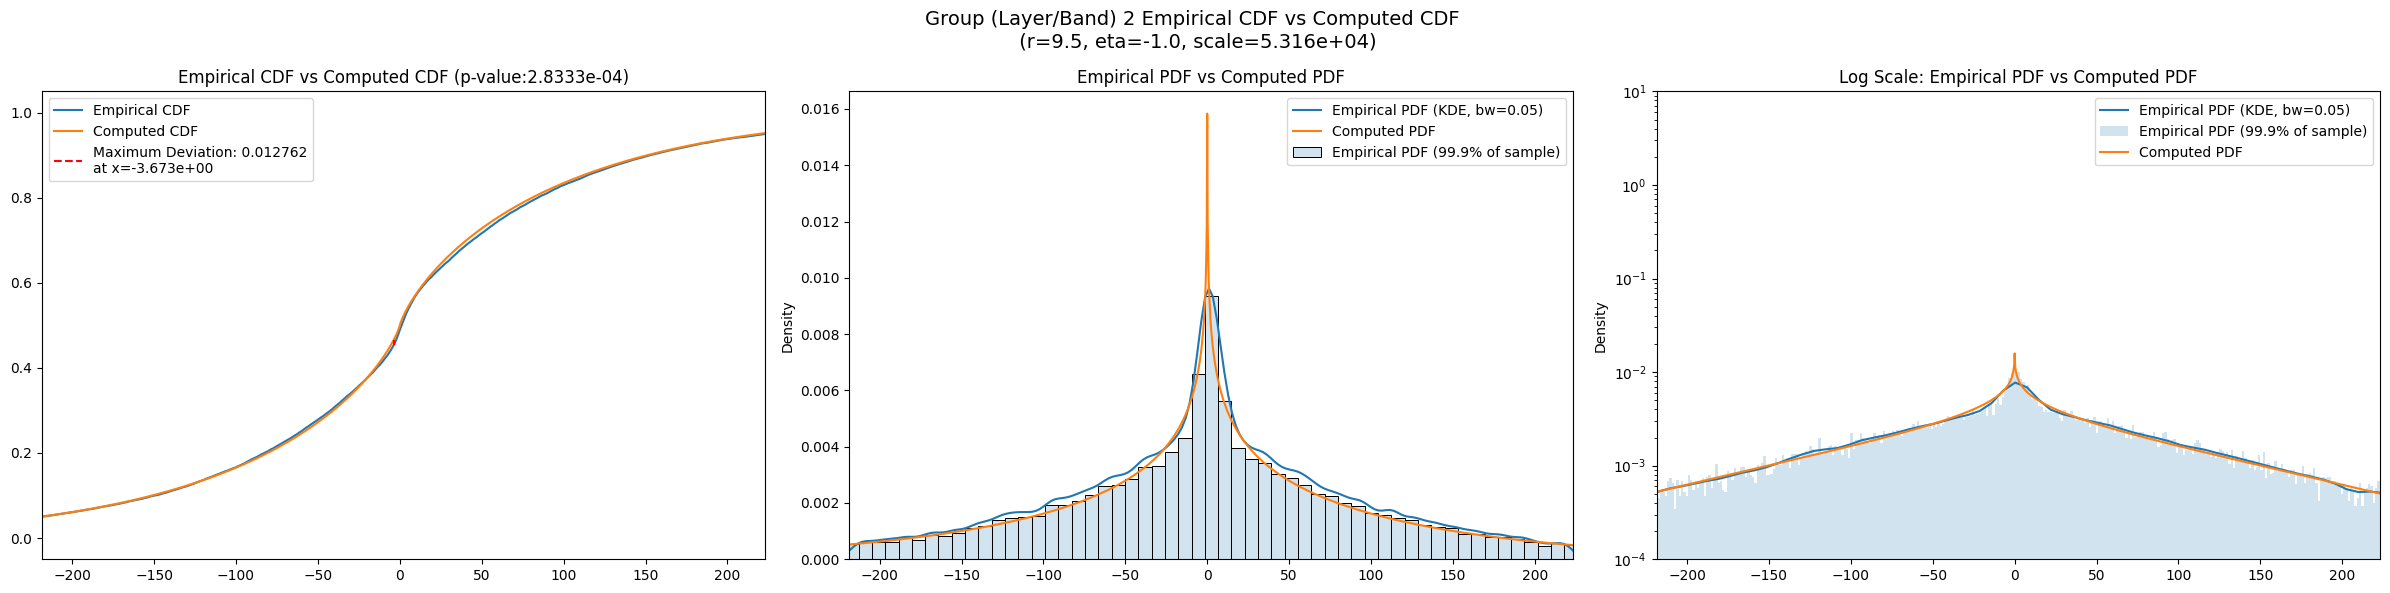

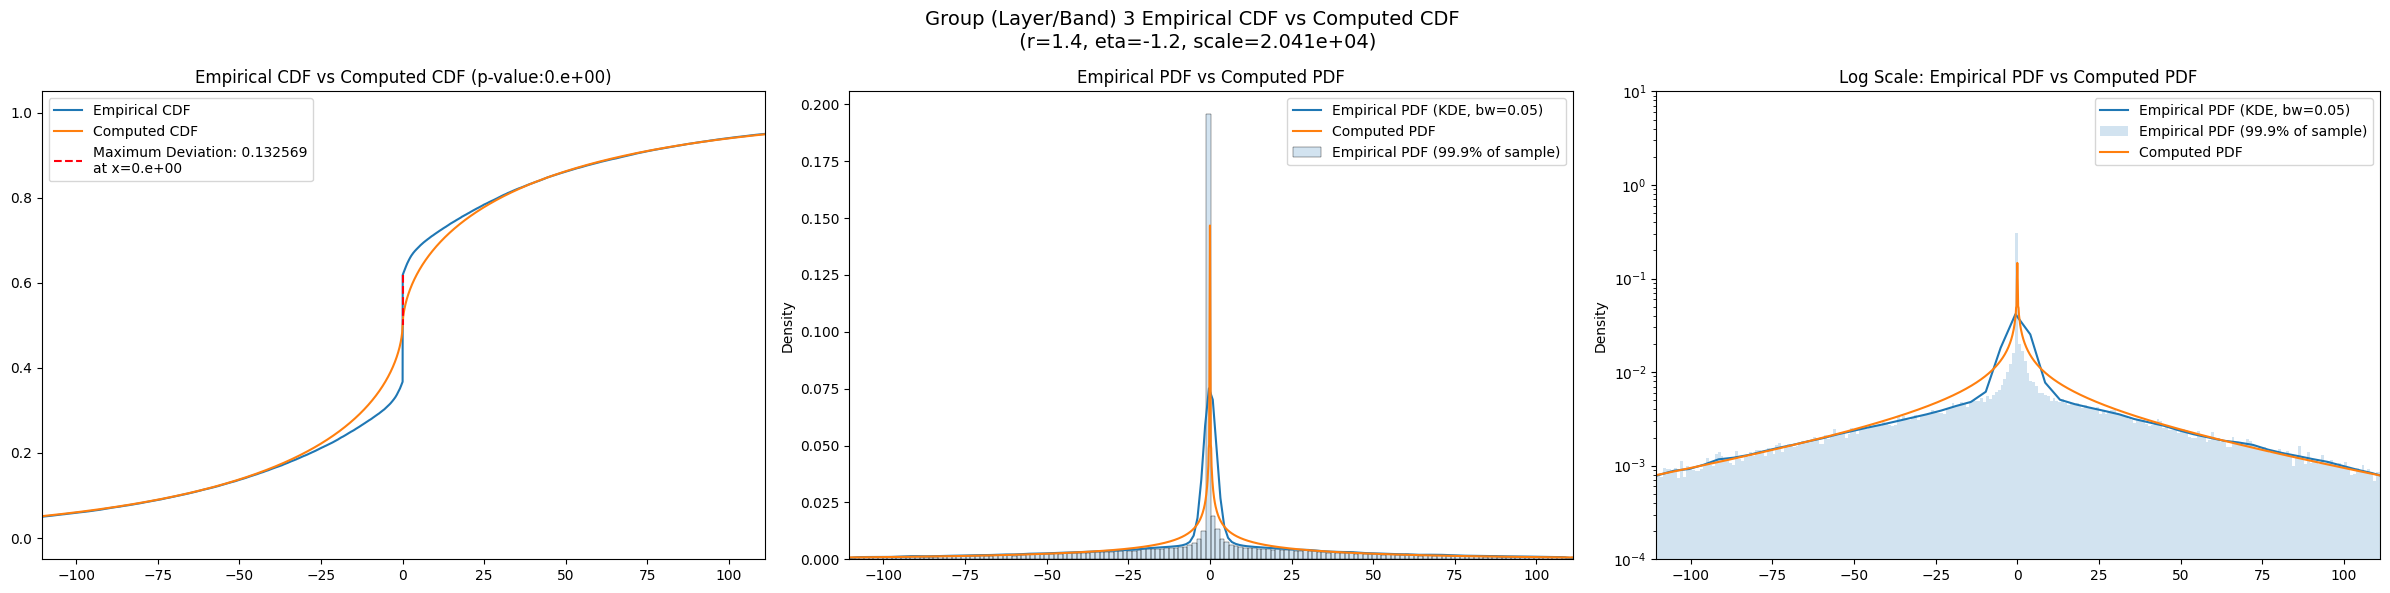

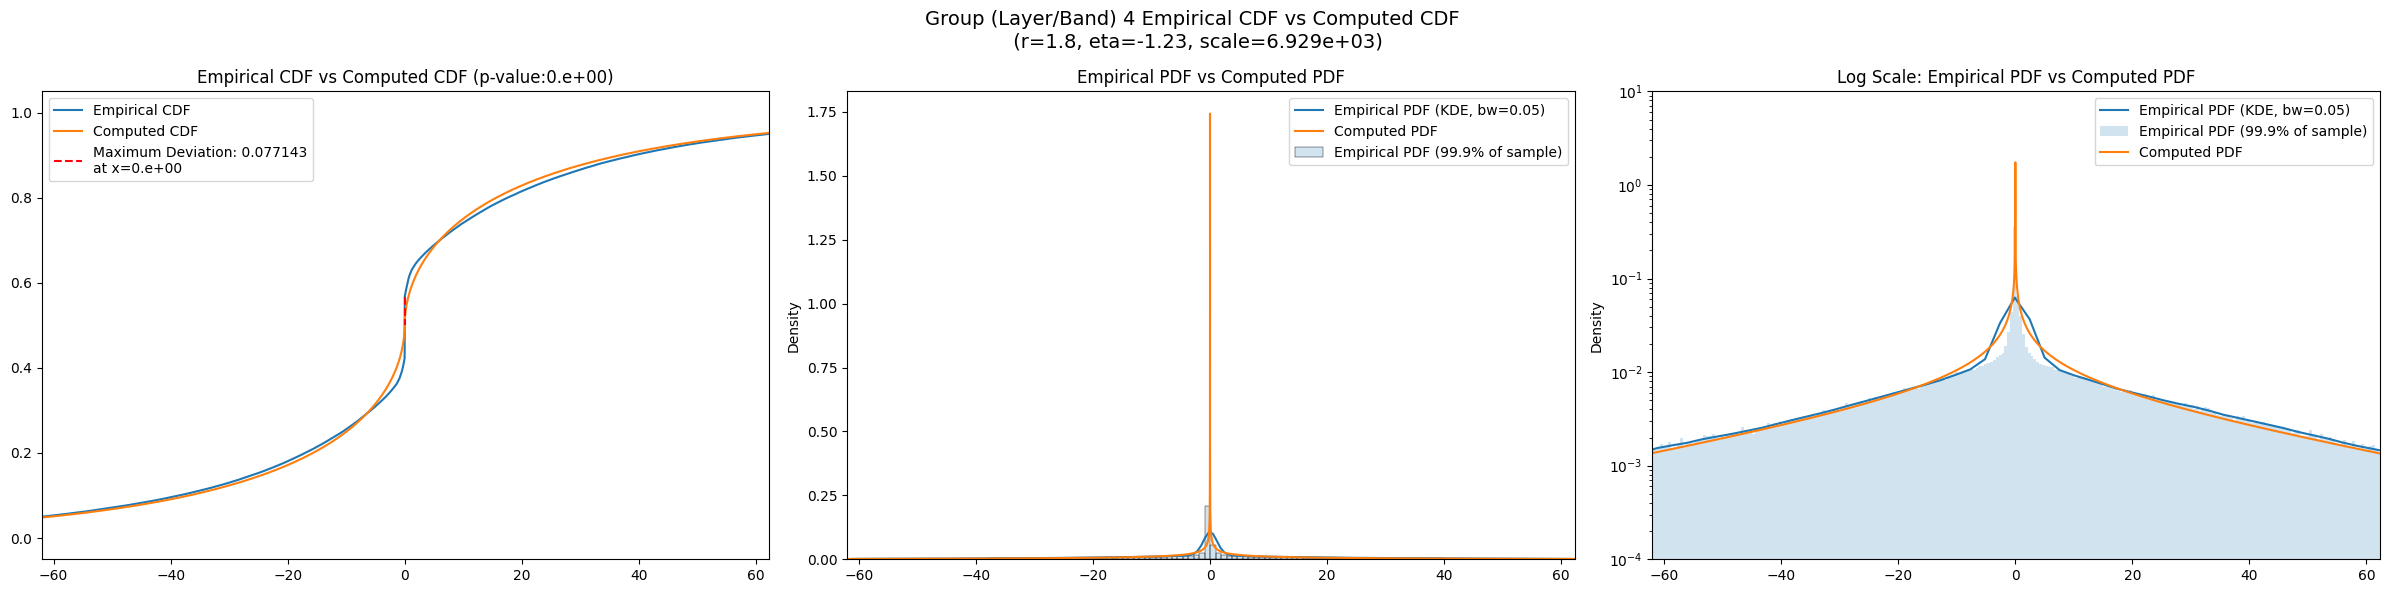

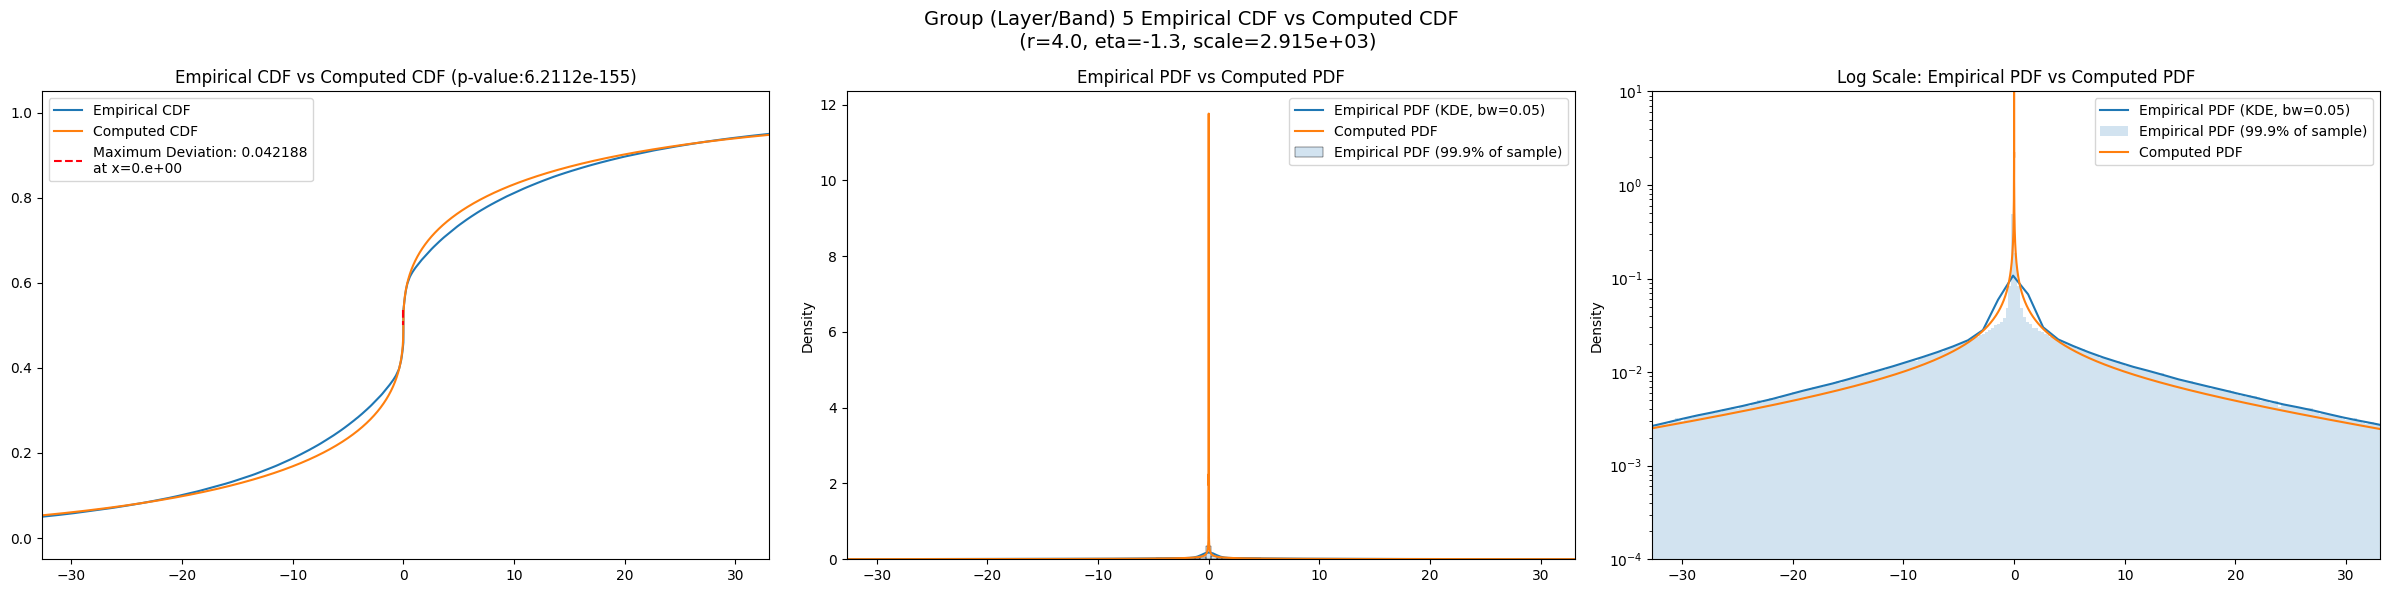

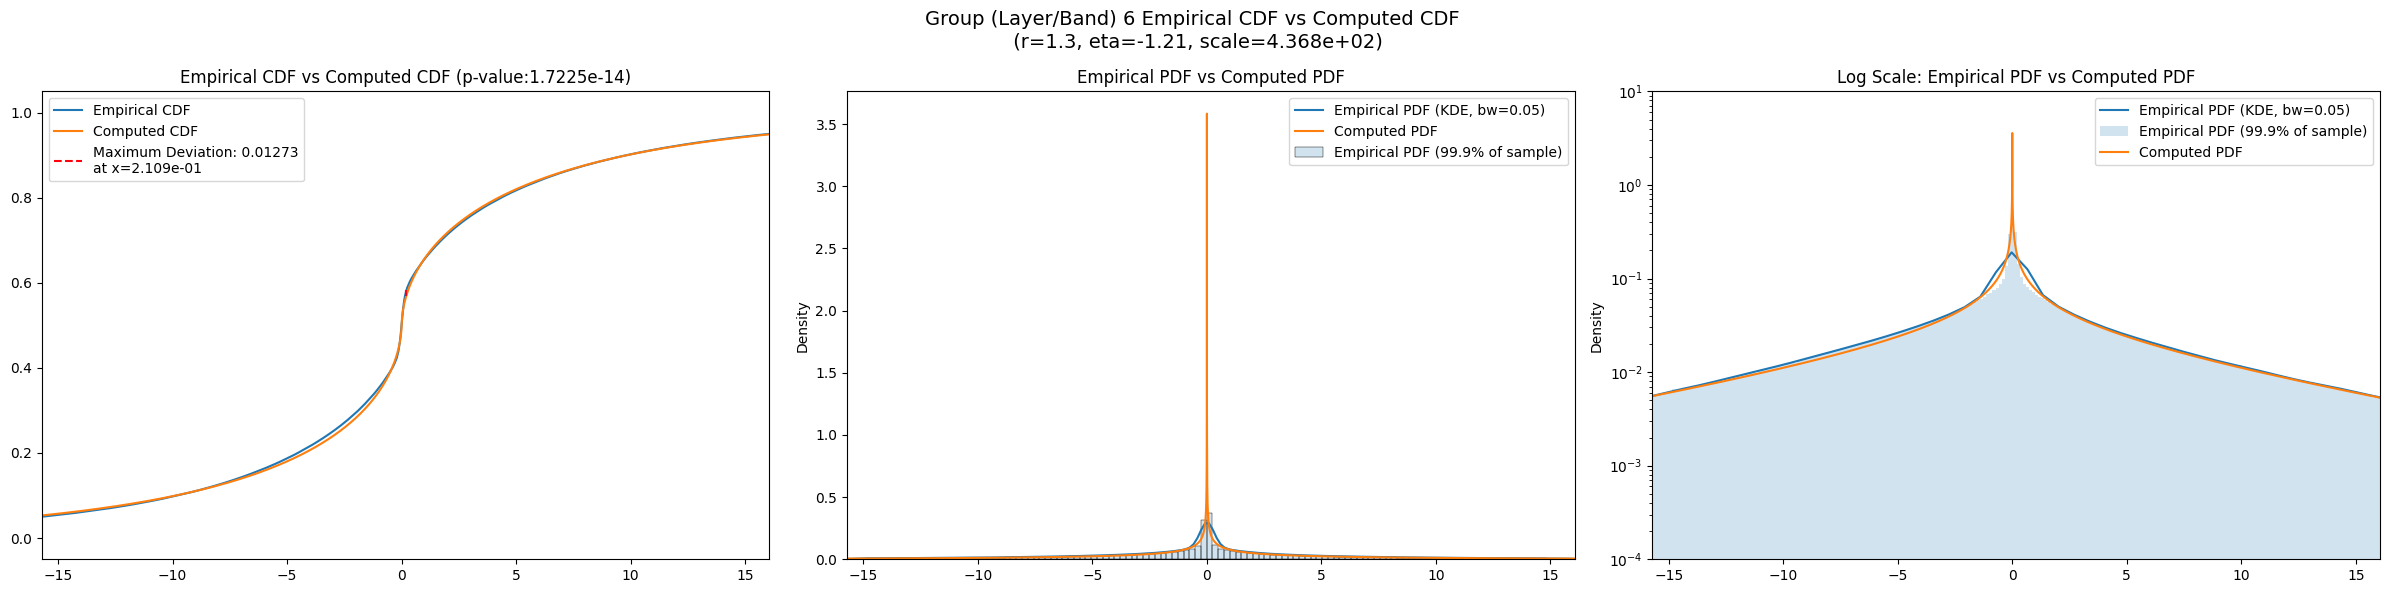

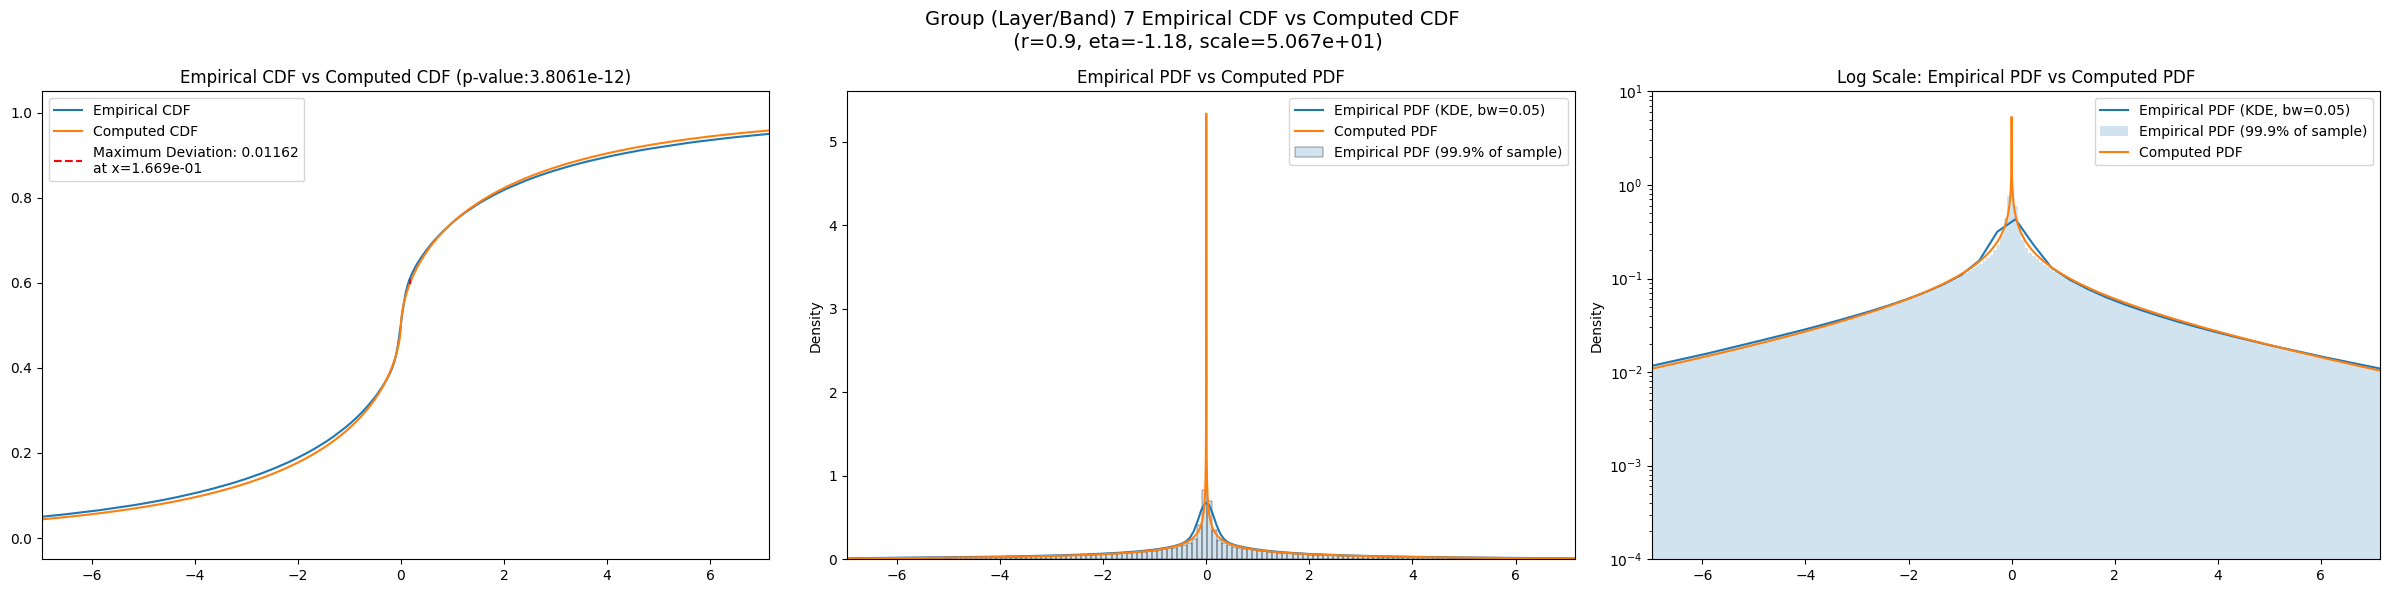

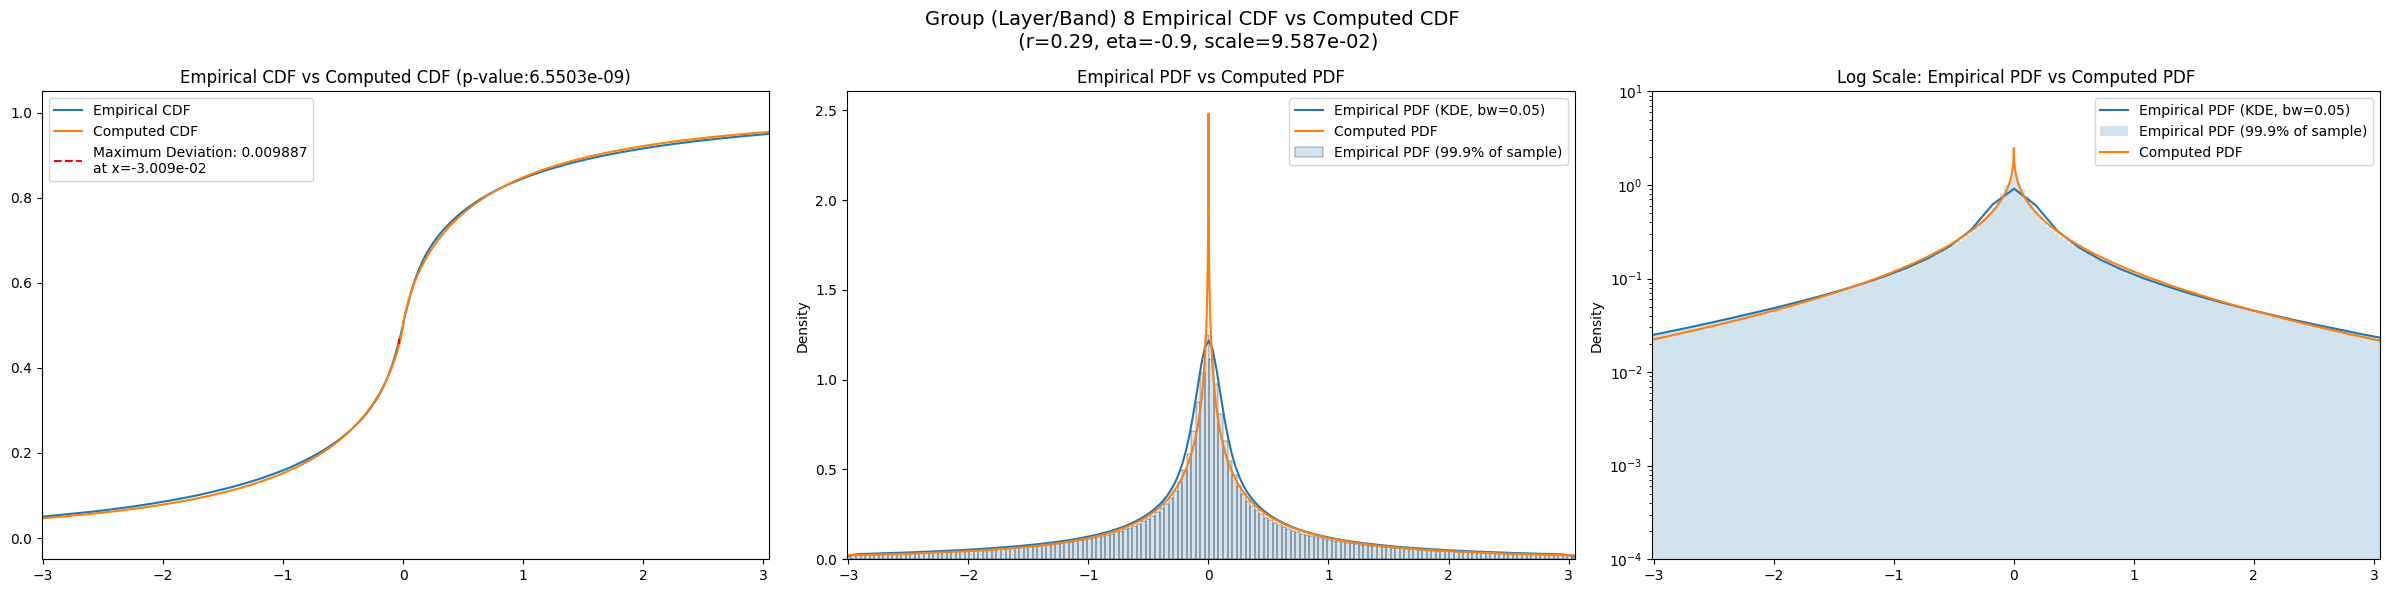

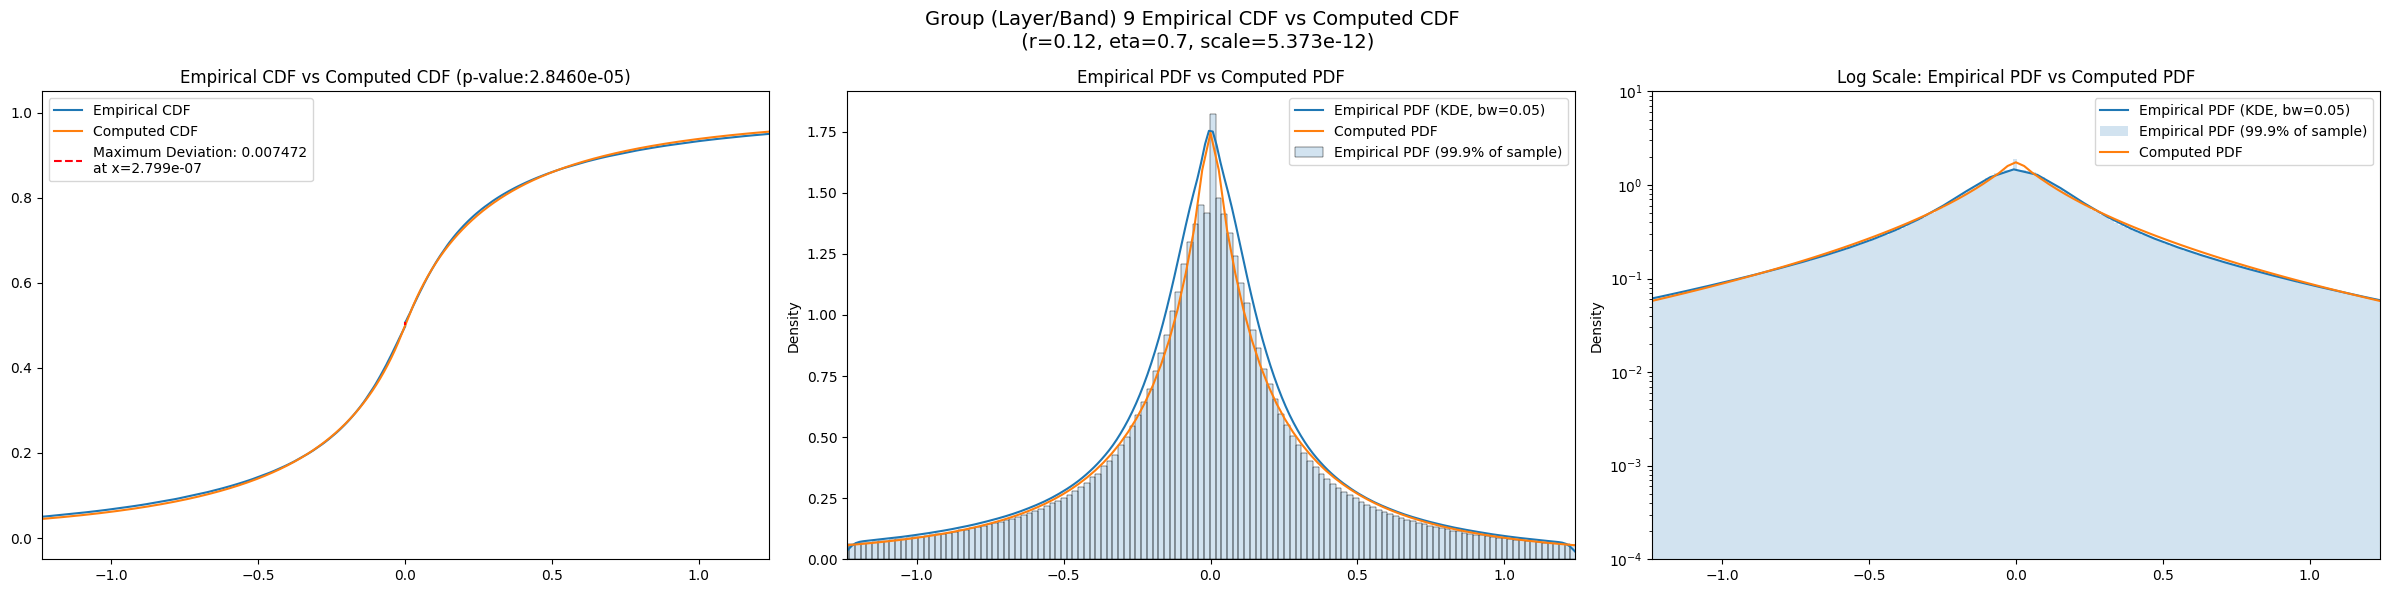

In [17]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [18]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [19]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,18678.610000,17502.572000,19935.389000,4.316036,2.885068,6.460766,27208.0,0.012717,9.5,-1.0,...,97.783800,0.044233,1.073510e-46,81.396700,0.026321,8.300720e-17,68.279900,0.031579,5.240460e-24,0.000299
3,5005.063500,4561.659000,5522.763000,11.797888,6.478233,25.283875,108832.0,0.132440,1.4,-1.2,...,21.694100,0.133661,0.000000e+00,14.961000,0.132445,0.000000e+00,12.082400,0.132451,0.000000e+00,0.000000
4,1581.178100,1451.108800,1726.036900,9.157593,6.195280,16.083124,333298.0,0.077070,1.4,-1.2,...,16.048900,0.103689,0.000000e+00,12.441900,0.090926,0.000000e+00,10.038900,0.093887,0.000000e+00,0.000000
5,447.847200,409.953770,492.383670,10.530340,6.367763,30.650787,1149538.0,0.042150,4.0,-1.3,...,9.329520,0.089743,0.000000e+00,7.243720,0.076202,0.000000e+00,5.830180,0.079129,0.000000e+00,0.000000
6,107.281980,98.076250,117.780870,10.589932,6.834965,22.540855,4251250.0,0.013955,1.1,-1.2,...,4.952390,0.076947,0.000000e+00,3.968450,0.059209,0.000000e+00,3.208150,0.062936,0.000000e+00,0.000000
7,23.563498,21.139431,26.704712,18.387585,9.488698,58.686512,17005000.0,0.012797,1.3,-1.2,...,2.014320,0.082259,0.000000e+00,1.660870,0.060900,0.000000e+00,1.319320,0.064368,0.000000e+00,0.000000
8,5.003841,4.364752,6.037876,36.420383,13.384377,160.108230,68020000.0,0.009946,0.3,-0.9,...,0.853967,0.078585,0.000000e+00,0.739292,0.052345,0.000000e+00,0.580551,0.053484,0.000000e+00,0.000000
9,0.925920,0.778517,1.293758,103.432570,15.223415,467.525050,272080000.0,0.007460,0.1,1.1,...,0.433596,0.058977,0.000000e+00,0.381957,0.031825,0.000000e+00,0.304260,0.030162,0.000000e+00,0.000000


## Results

In [20]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [21]:
master_df.filter(regex="kstest_stat.*")

,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_best,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
layer,,,,,,
2,0.012717,0.008227,0.012717,0.044233,0.026321,0.031579
3,0.132440,0.004115,0.132440,0.133661,0.132445,0.132451
4,0.077070,0.002352,0.077070,0.103689,0.090926,0.093887
5,0.042150,0.001267,0.042150,0.089743,0.076202,0.079129
6,0.013955,0.000659,0.012641,0.076947,0.059209,0.062936
7,0.012797,0.000329,0.011776,0.082259,0.060900,0.064368
8,0.009946,0.000165,0.009915,0.078585,0.052345,0.053484
9,0.007460,0.000082,0.007460,0.058977,0.031825,0.030162


In [22]:
master_df.filter(regex="best.*")

,best_augmented_var,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff
layer,,,,,,
2,16957.357000,0.012717,9.50,-1.00,5.315531e+04,50.0
3,5005.063500,0.132440,1.40,-1.20,2.040829e+04,0.0
4,1436.250122,0.077070,1.80,-1.23,6.929007e+03,100.0
5,447.847200,0.042150,4.00,-1.30,2.914732e+03,0.0
6,107.281982,0.012641,1.30,-1.21,4.368110e+02,0.0
7,17.914526,0.011776,0.90,-1.18,5.066840e+01,325.0
8,5.003841,0.009915,0.29,-0.90,9.587160e-02,0.0
9,0.786197,0.007460,0.12,0.70,5.373115e-12,50.0


In [23]:
eng.quit()